# 数据结构导论 - 第二次作业实验

## 实验题目：房屋价格数据分析与预处理

**实验日期：** 2025年9月22日

---
## 实验内容及要求
【内容描述】利用给出的房屋价格数据集，进行以下任务：
1. 缺失值的检测与缺失值处理
2. 异常值检测
3. 特征间的相关性分析
4. 对price属性进行标准化
5. 根据price属性进行离散化
6. 找出与price（房价）相关性最高的三个特征，并给出合理的解释

## 实验环境
采用Python语言并利用Jupyter Notebook编程实现。

---

## 1. 导入必要的库和数据

In [3]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
from scipy.stats import zscore
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 中文字体优先级
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (10, 6)  # 默认图片大小
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)  # 设置字体大小
warnings.filterwarnings('ignore')

# 验证中文字体设置
print("当前matplotlib字体设置:")
print(f"字体族: {plt.rcParams['font.sans-serif']}")

当前matplotlib字体设置:
字体族: ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']


In [4]:
# 修复中文字体显示问题 - 使用系统字体路径
import matplotlib.font_manager as fm
import os

# 查找系统中的中文字体
def find_chinese_fonts():
    chinese_fonts_found = []
    system_fonts = fm.findSystemFonts()
    
    for font_path in system_fonts:
        try:
            font_prop = fm.FontProperties(fname=font_path)
            font_name = font_prop.get_name()
            if any(chinese in font_name.lower() for chinese in ['simhei', 'simsun', 'yahei', 'kaiti']):
                chinese_fonts_found.append(font_name)
        except:
            continue
    
    return list(set(chinese_fonts_found))

# 查找并设置中文字体
chinese_fonts = find_chinese_fonts()
if chinese_fonts:
    font_to_use = chinese_fonts[0]
    plt.rcParams['font.sans-serif'] = [font_to_use] + ['Arial', 'DejaVu Sans']
    print(f"找到并设置中文字体: {font_to_use}")
else:
    # 如果找不到中文字体，使用备选方案
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    print("未找到中文字体，使用默认字体")

plt.rcParams['axes.unicode_minus'] = False


找到并设置中文字体: STKaiti


In [5]:
# 加载数据
data_path = r'data/train.csv'
df = pd.read_csv(data_path)

print(f"数据集形状: {df.shape}")
print(f"数据集包含 {df.shape[0]} 行，{df.shape[1]} 列")

# 显示数据集的前几行
print("\n数据集前5行:")
df.head()

数据集形状: (1460, 81)
数据集包含 1460 行，81 列

数据集前5行:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. 缺失值检测

In [6]:
# 全面检测缺失值
def analyze_missing_data(df):
    """全面分析缺失值情况"""
    missing_stats = pd.DataFrame()
    missing_stats['缺失数量'] = df.isnull().sum()
    missing_stats['缺失比例(%)'] = (df.isnull().sum() / len(df)) * 100
    missing_stats['数据类型'] = df.dtypes
    
    # 只显示有缺失值的列
    missing_stats = missing_stats[missing_stats['缺失数量'] > 0]
    missing_stats = missing_stats.sort_values('缺失数量', ascending=False)
    
    return missing_stats

missing_analysis = analyze_missing_data(df)
print(f"总共有 {len(missing_analysis)} 个变量存在缺失值")
print(f"数据集总体缺失值比例: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")
print("\n缺失值详细统计:")
missing_analysis

总共有 19 个变量存在缺失值
数据集总体缺失值比例: 6.62%

缺失值详细统计:


,缺失数量,缺失比例(%),数据类型
PoolQC,1453,99.520548,object
MiscFeature,1406,96.301370,object
Alley,1369,93.767123,object
Fence,1179,80.753425,object
MasVnrType,872,59.726027,object
FireplaceQu,690,47.260274,object
LotFrontage,259,17.739726,float64
GarageType,81,5.547945,object
GarageYrBlt,81,5.547945,float64
GarageFinish,81,5.547945,object


## 3. 缺失值处理

采用科学的缺失值处理策略：

### 处理策略说明：
1. **缺失比例过高的特征**：删除缺失比例 > 50% 的特征，避免影响分析质量
2. **数值型特征**：用中位数（median）填充，因为中位数对异常值不敏感
3. **分类型特征**：用众数（mode）填充，保持分类变量的主要特征

In [ ]:
# 创建处理后的数据副本
df_processed = df.copy()

# 步骤1：识别并删除缺失比例过高的特征
missing_threshold = 0.5
missing_ratios = df_processed.isnull().sum() / len(df_processed)
high_missing_cols = missing_ratios[missing_ratios > missing_threshold].index.tolist()

print(f"缺失比例 > {missing_threshold*100}% 的特征 ({len(high_missing_cols)}个):")
for col in high_missing_cols:
    print(f"  - {col}: {missing_ratios[col]*100:.1f}% 缺失")

# 删除高缺失比例的特征
df_processed = df_processed.drop(columns=high_missing_cols)
print(f"\n删除后数据形状: {df_processed.shape}")

# 步骤2：处理剩余的缺失值
print(f"\n=== 处理剩余缺失值 ===")

# 分离数值型和分类型特征
numerical_cols_remaining = df_processed.select_dtypes(include=[np.number]).columns
categorical_cols_remaining = df_processed.select_dtypes(include=['object']).columns

# 处理数值型特征（用中位数）
numerical_missing = df_processed[numerical_cols_remaining].isnull().sum()
numerical_missing = numerical_missing[numerical_missing > 0]

for col in numerical_missing.index:
    median_val = df_processed[col].median()
    df_processed[col] = df_processed[col].fillna(median_val)
    print(f"数值型 {col}: 用中位数 {median_val:.2f} 填充 {numerical_missing[col]} 个缺失值")

# 处理分类型特征（用众数）
categorical_missing = df_processed[categorical_cols_remaining].isnull().sum()
categorical_missing = categorical_missing[categorical_missing > 0]

for col in categorical_missing.index:
    mode_val = df_processed[col].mode()[0] if len(df_processed[col].mode()) > 0 else 'Unknown'
    df_processed[col] = df_processed[col].fillna(mode_val)
    print(f"分类型 {col}: 用众数 '{mode_val}' 填充 {categorical_missing[col]} 个缺失值")

print(f"\n处理完成后的数据形状: {df_processed.shape}")
print(f"剩余缺失值总数: {df_processed.isnull().sum().sum()}")

print("\n第1题：缺失值检测与处理（新策略）- 完成✓")

=== 新缺失值处理策略 ===
1. 删除缺失比例 > 50% 的特征
2. 数值型特征用中位数填充
3. 分类型特征用众数填充

缺失比例 > 50.0% 的特征 (5个):
  - Alley: 93.8% 缺失
  - MasVnrType: 59.7% 缺失
  - PoolQC: 99.5% 缺失
  - Fence: 80.8% 缺失
  - MiscFeature: 96.3% 缺失

删除后数据形状: (1460, 76)

=== 处理剩余缺失值 ===
数值型 LotFrontage: 用中位数 69.00 填充 259 个缺失值
数值型 MasVnrArea: 用中位数 0.00 填充 8 个缺失值
数值型 GarageYrBlt: 用中位数 1980.00 填充 81 个缺失值
分类型 BsmtQual: 用众数 'TA' 填充 37 个缺失值
分类型 BsmtCond: 用众数 'TA' 填充 37 个缺失值
分类型 BsmtExposure: 用众数 'No' 填充 38 个缺失值
分类型 BsmtFinType1: 用众数 'Unf' 填充 37 个缺失值
分类型 BsmtFinType2: 用众数 'Unf' 填充 38 个缺失值
分类型 Electrical: 用众数 'SBrkr' 填充 1 个缺失值
分类型 FireplaceQu: 用众数 'Gd' 填充 690 个缺失值
分类型 GarageType: 用众数 'Attchd' 填充 81 个缺失值
分类型 GarageFinish: 用众数 'Unf' 填充 81 个缺失值
分类型 GarageQual: 用众数 'TA' 填充 81 个缺失值
分类型 GarageCond: 用众数 'TA' 填充 81 个缺失值

处理完成后的数据形状: (1460, 76)
剩余缺失值总数: 0

第1题：缺失值检测与处理（新策略）- 完成✓


In [8]:
# 输出缺失值处理后的数据到CSV文件
import os

# 确保data文件夹存在
os.makedirs("data", exist_ok=True)

# 保存缺失值处理后的数据
output_file_missing = "data/data_after_step1.csv"
try:
    # 如果文件已存在，尝试删除
    if os.path.exists(output_file_missing):
        os.remove(output_file_missing)
    df_processed.to_csv(output_file_missing, index=False, encoding='utf-8-sig')
except PermissionError as e:
    print(f"文件写入权限错误: {e}")
    print("请关闭正在使用该文件的所有程序后重试，或检查文件夹权限。")
except Exception as e:
    print(f"保存文件时发生其他错误: {e}")

print(f"=== 缺失值处理后数据保存 ===")
print(f"保存路径: {output_file_missing}")
print(f"保存数据形状: {df_processed.shape}")
print(f"删除的高缺失比例特征: {high_missing_cols}")
print(f"剩余缺失值总数: {df_processed.isnull().sum().sum()}")

# 验证保存的文件
try:
    test_missing_df = pd.read_csv(output_file_missing)
    print(f"验证读取成功: {test_missing_df.shape}")
    print("缺失值处理数据文件保存和验证完成✓")
except Exception as e:
    print(f"文件验证失败: {e}")

print("=" * 50)

=== 缺失值处理后数据保存 ===
保存路径: data/data_after_step1.csv
保存数据形状: (1460, 76)
删除的高缺失比例特征: ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']
剩余缺失值总数: 0
验证读取成功: (1460, 76)
缺失值处理数据文件保存和验证完成✓


## 5. 异常值检测

In [9]:
# 基于保存的CSV文件进行异常值检测
print("=== 第2题：异常值检测 ===")
print("基于缺失值处理后保存的数据文件进行异常值检测")

# 从保存的CSV文件加载数据
data_file_path = "data/data_after_step1.csv"
print(f"加载数据文件: {data_file_path}")

try:
    df_for_outlier = pd.read_csv(data_file_path, encoding='utf-8-sig')
    print(f"成功加载数据: {df_for_outlier.shape}")
    print(f"缺失值检查: {df_for_outlier.isnull().sum().sum()} 个缺失值")
except Exception as e:
    print(f"加载文件失败: {e}")
    print("使用内存中的df_processed数据")
    df_for_outlier = df_processed.copy()

print()

# 选择关键数值变量进行异常值检测
key_vars = ['SalePrice', 'LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'OverallQual']

# IQR方法检测异常值
def detect_outliers_iqr(data, columns):
    outliers = {}
    for col in columns:
        if col in data.columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outlier_mask = (data[col] < lower) | (data[col] > upper)
            outliers[col] = outlier_mask.sum()
    return outliers

# 执行IQR异常值检测
outliers_iqr = detect_outliers_iqr(df_for_outlier, key_vars)

print("=== IQR方法异常值检测结果 ===")
for var, count in outliers_iqr.items():
    print(f"{var}: {count}个异常值")

print("\n第2题：异常值检测 - 完成✓")

=== 第2题：异常值检测 ===
基于缺失值处理后保存的数据文件进行异常值检测
加载数据文件: data/data_after_step1.csv
成功加载数据: (1460, 76)
缺失值检查: 0 个缺失值

=== IQR方法异常值检测结果 ===
SalePrice: 61个异常值
LotArea: 69个异常值
GrLivArea: 31个异常值
TotalBsmtSF: 61个异常值
GarageArea: 21个异常值
OverallQual: 2个异常值

第2题：异常值检测 - 完成✓


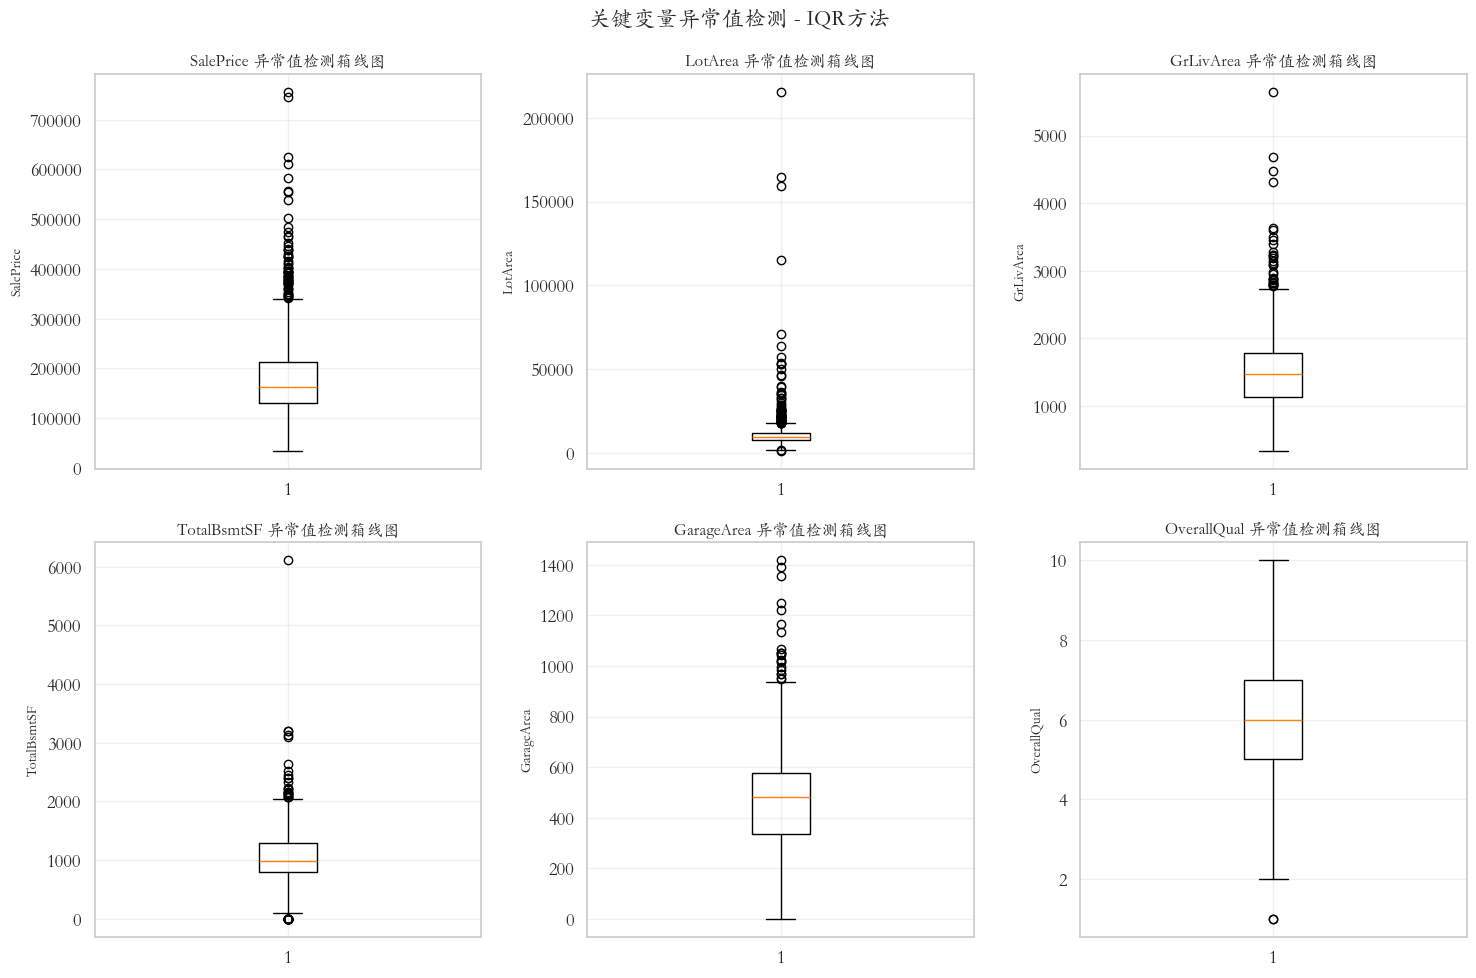

In [10]:
# 绘制关键变量的箱线图
plt.figure(figsize=(15, 10))
for i, var in enumerate(key_vars, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(df_for_outlier[var].dropna())
    plt.title(f'{var} 异常值检测箱线图', fontsize=12)
    plt.ylabel(var, fontsize=10)
    plt.grid(True, alpha=0.3)

plt.suptitle('关键变量异常值检测 - IQR方法', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

In [11]:
# 删除异常值数据
print("=== 删除异常值数据 ===")
print(f"删除前数据形状: {df_for_outlier.shape}")

# 使用IQR方法标识并删除异常值
def remove_outliers_iqr(data, columns):
    """删除IQR方法检测到的异常值"""
    clean_data = data.copy()
    removed_count = 0
    
    for col in columns:
        if col in clean_data.columns:
            Q1 = clean_data[col].quantile(0.25)
            Q3 = clean_data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            
            # 找到异常值的索引
            outlier_mask = (clean_data[col] < lower) | (clean_data[col] > upper)
            outlier_count = outlier_mask.sum()
            
            # 删除异常值
            clean_data = clean_data[~outlier_mask]
            removed_count += outlier_count
            
            print(f"{col}: 删除 {outlier_count} 个异常值")
    
    return clean_data, removed_count

# 执行异常值删除
df_clean, total_removed = remove_outliers_iqr(df_for_outlier, key_vars)

print(f"\n删除后数据形状: {df_clean.shape}")
print(f"总共删除: {total_removed} 行异常数据")
print(f"数据保留率: {(len(df_clean)/len(df_for_outlier)*100):.2f}%")

print("\n异常值删除 - 完成✓")

=== 删除异常值数据 ===
删除前数据形状: (1460, 76)
SalePrice: 删除 61 个异常值
LotArea: 删除 73 个异常值
GrLivArea: 删除 19 个异常值
TotalBsmtSF: 删除 50 个异常值
GarageArea: 删除 4 个异常值
OverallQual: 删除 1 个异常值

删除后数据形状: (1252, 76)
总共删除: 208 行异常数据
数据保留率: 85.75%

异常值删除 - 完成✓


=== 删除异常值后的数据验证 ===
删除异常值后剩余异常值数量:
  SalePrice: 37个
  LotArea: 21个
  GrLivArea: 6个
  TotalBsmtSF: 0个
  GarageArea: 1个
  OverallQual: 0个


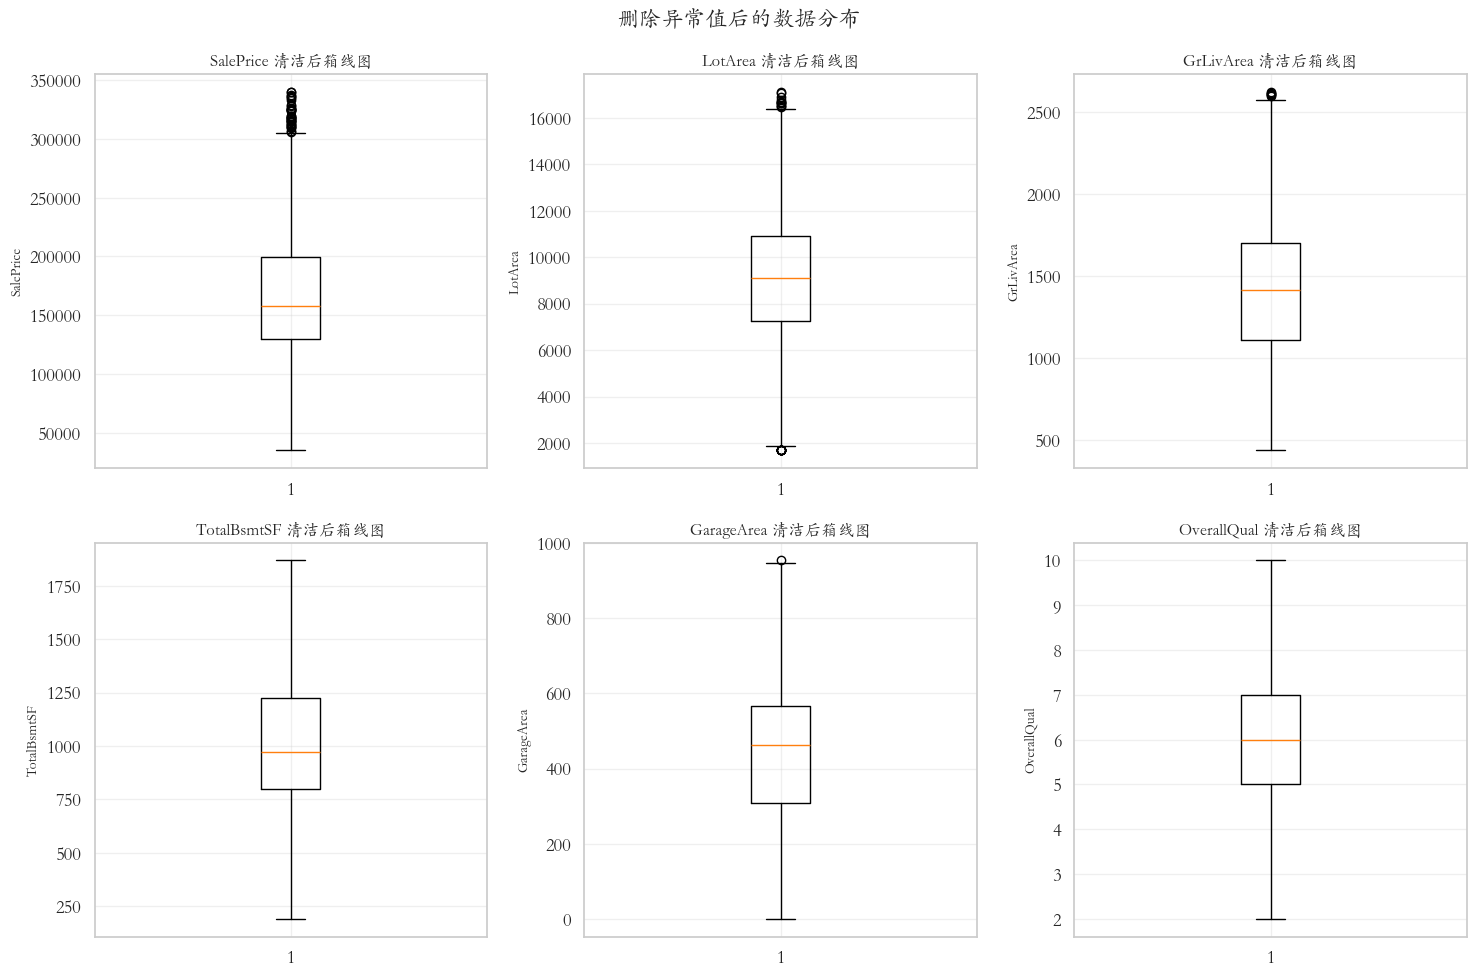


数据清洁验证完成✓


In [12]:
# 验证异常值删除效果 - 重新绘制箱线图
print("=== 删除异常值后的数据验证 ===")

# 重新检测剩余异常值
outliers_after_clean = detect_outliers_iqr(df_clean, key_vars)
print("删除异常值后剩余异常值数量:")
for var, count in outliers_after_clean.items():
    print(f"  {var}: {count}个")

# 绘制清洁后数据的箱线图
plt.figure(figsize=(15, 10))
for i, var in enumerate(key_vars, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(df_clean[var].dropna())
    plt.title(f'{var} 清洁后箱线图', fontsize=12)
    plt.ylabel(var, fontsize=10)
    plt.grid(True, alpha=0.3)

plt.suptitle('删除异常值后的数据分布', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print("\n数据清洁验证完成✓")

## 6. 输出处理后的数据

In [13]:
# 将清洁后的数据保存为新文件
output_file = 'data/data_after_step1_2.csv'
df_clean.to_csv(output_file, index=False, encoding='utf-8')

print(f"=== 清洁数据文件保存成功 ===")
print(f"保存路径: {output_file}")
print(f"保存数据形状: {df_clean.shape}")
print(f"文件大小: {round(df_clean.memory_usage(deep=True).sum() / 1024**2, 2)} MB")

print(f"\n=== 数据处理总结 ===")
print(f"原始数据: {df.shape[0]} 行")
print(f"处理缺失值后: {df_processed.shape[0]} 行")
print(f"删除异常值后: {df_clean.shape[0]} 行")
print(f"数据保留率: {(len(df_clean)/len(df)*100):.2f}%")

# 验证保存的文件
try:
    test_df = pd.read_csv(output_file)
    print(f"验证读取成功: {test_df.shape}")
    print("文件保存和读取验证完成✓")
except Exception as e:
    print(f"文件验证失败: {e}")


=== 清洁数据文件保存成功 ===
保存路径: data/data_after_step1_2.csv
保存数据形状: (1252, 76)
文件大小: 2.76 MB

=== 数据处理总结 ===
原始数据: 1460 行
处理缺失值后: 1460 行
删除异常值后: 1252 行
数据保留率: 85.75%
验证读取成功: (1252, 76)
文件保存和读取验证完成✓


## 7. 特征间的相关性分析

使用皮尔逊相关系数分析特征间的相关性，并绘制热力图进行可视化。

In [14]:
# 第三问：基于皮尔逊相关系数的特征相关性分析（包含分类变量编码）
print("=== 第3题：特征间的相关性分析 ===")
print("基于皮尔逊相关系数分析特征间的相关性关系（包含分类变量数值编码）")

# 从保存的最终清洁数据文件加载数据
correlation_data_file = 'data/data_after_step1_2.csv'
print(f"加载数据文件: {correlation_data_file}")

try:
    df_correlation = pd.read_csv(correlation_data_file, encoding='utf-8')
    print(f"成功加载数据: {df_correlation.shape}")
    print(f"缺失值检查: {df_correlation.isnull().sum().sum()} 个缺失值")
except Exception as e:
    print(f"加载文件失败: {e}")
    print("使用内存中的df_clean数据")
    df_correlation = df_clean.copy()

print()

# 数据类型分析
numerical_features = df_correlation.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_correlation.select_dtypes(include=['object']).columns.tolist()

print(f"数据类型分析：")
print(f"   - 数值型特征: {len(numerical_features)}个")
print(f"   - 分类型特征: {len(categorical_features)}个")
print(f"   - 总特征数: {len(numerical_features) + len(categorical_features)}个")

print(f"\n分类特征列表 (前10个): {categorical_features[:10]}")

# 分类变量编码处理
print("\n=== 分类变量数值编码处理 ===")
df_encoded = df_correlation.copy()

# 使用LabelEncoder对分类变量进行编码
from sklearn.preprocessing import LabelEncoder

encoded_info = {}
for col in categorical_features:
    if col in df_encoded.columns:
        le = LabelEncoder()
        # 处理缺失值
        df_encoded[col] = df_encoded[col].fillna('Unknown')
        
        # 获取原始唯一值数量
        original_unique = df_encoded[col].nunique()
        original_values = df_encoded[col].unique()
        
        # 进行标签编码，直接替换原列
        df_encoded[col] = le.fit_transform(df_encoded[col])
        
        # 保存编码信息
        encoded_info[col] = {
            'original_col': col,
            'unique_values': original_unique,
            'original_categories': original_values,
            'encoding_map': dict(zip(le.classes_, le.transform(le.classes_)))
        }
        
        print(f"   {col}: {original_unique}个类别 → 数值编码 (0-{original_unique-1})")

print(f"\n编码完成: {len(encoded_info)}个分类特征直接转换为数值特征")
print(f"数据维度: {df_encoded.shape[0]}行 × {df_encoded.shape[1]}列")

# 选择所有数值特征（包括编码后的分类特征）
encoded_numerical_features = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

# 排除标准化后的衍生变量，保留原始特征和编码特征
analysis_features = [col for col in encoded_numerical_features 
                    if not col.endswith('_zscore') and not col.endswith('_minmax')]

print(f"\n用于相关性分析的特征：")
print(f"   - 原始数值特征: {len(numerical_features)}个")
print(f"   - 编码分类特征: {len(encoded_info)}个") 
print(f"   - 总分析特征: {len(analysis_features)}个")

# 计算皮尔逊相关系数矩阵
print(f"\n计算包含所有特征的皮尔逊相关系数矩阵...")
correlation_matrix = df_encoded[analysis_features].corr(method='pearson')

print(f"相关性矩阵维度: {correlation_matrix.shape}")
print("第3题：特征相关性分析数据准备（含分类变量编码） - 完成✓")

=== 第3题：特征间的相关性分析 ===
基于皮尔逊相关系数分析特征间的相关性关系（包含分类变量数值编码）
加载数据文件: data/data_after_step1_2.csv
成功加载数据: (1252, 76)
缺失值检查: 0 个缺失值

数据类型分析：
   - 数值型特征: 38个
   - 分类型特征: 38个
   - 总特征数: 76个

分类特征列表 (前10个): ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2']

=== 分类变量数值编码处理 ===
   MSZoning: 5个类别 → 数值编码 (0-4)
   Street: 2个类别 → 数值编码 (0-1)
   LotShape: 4个类别 → 数值编码 (0-3)
   LandContour: 4个类别 → 数值编码 (0-3)
   Utilities: 2个类别 → 数值编码 (0-1)
   LotConfig: 5个类别 → 数值编码 (0-4)
   LandSlope: 3个类别 → 数值编码 (0-2)
   Neighborhood: 25个类别 → 数值编码 (0-24)
   Condition1: 9个类别 → 数值编码 (0-8)
   Condition2: 5个类别 → 数值编码 (0-4)
   BldgType: 5个类别 → 数值编码 (0-4)
   HouseStyle: 8个类别 → 数值编码 (0-7)
   RoofStyle: 5个类别 → 数值编码 (0-4)
   RoofMatl: 5个类别 → 数值编码 (0-4)
   Exterior1st: 14个类别 → 数值编码 (0-13)
   Exterior2nd: 16个类别 → 数值编码 (0-15)
   ExterQual: 4个类别 → 数值编码 (0-3)
   ExterCond: 5个类别 → 数值编码 (0-4)
   Foundation: 5个类别 → 数值编码 (0-4)
   BsmtQual: 4个类别 → 数值编码 (0-3)


=== 绘制所有变量相关性热力图（含分类特征编码） ===
📊 绘制 76 × 76 完整相关性热力图
   包含 76 个数值特征
   包含 0 个编码分类特征


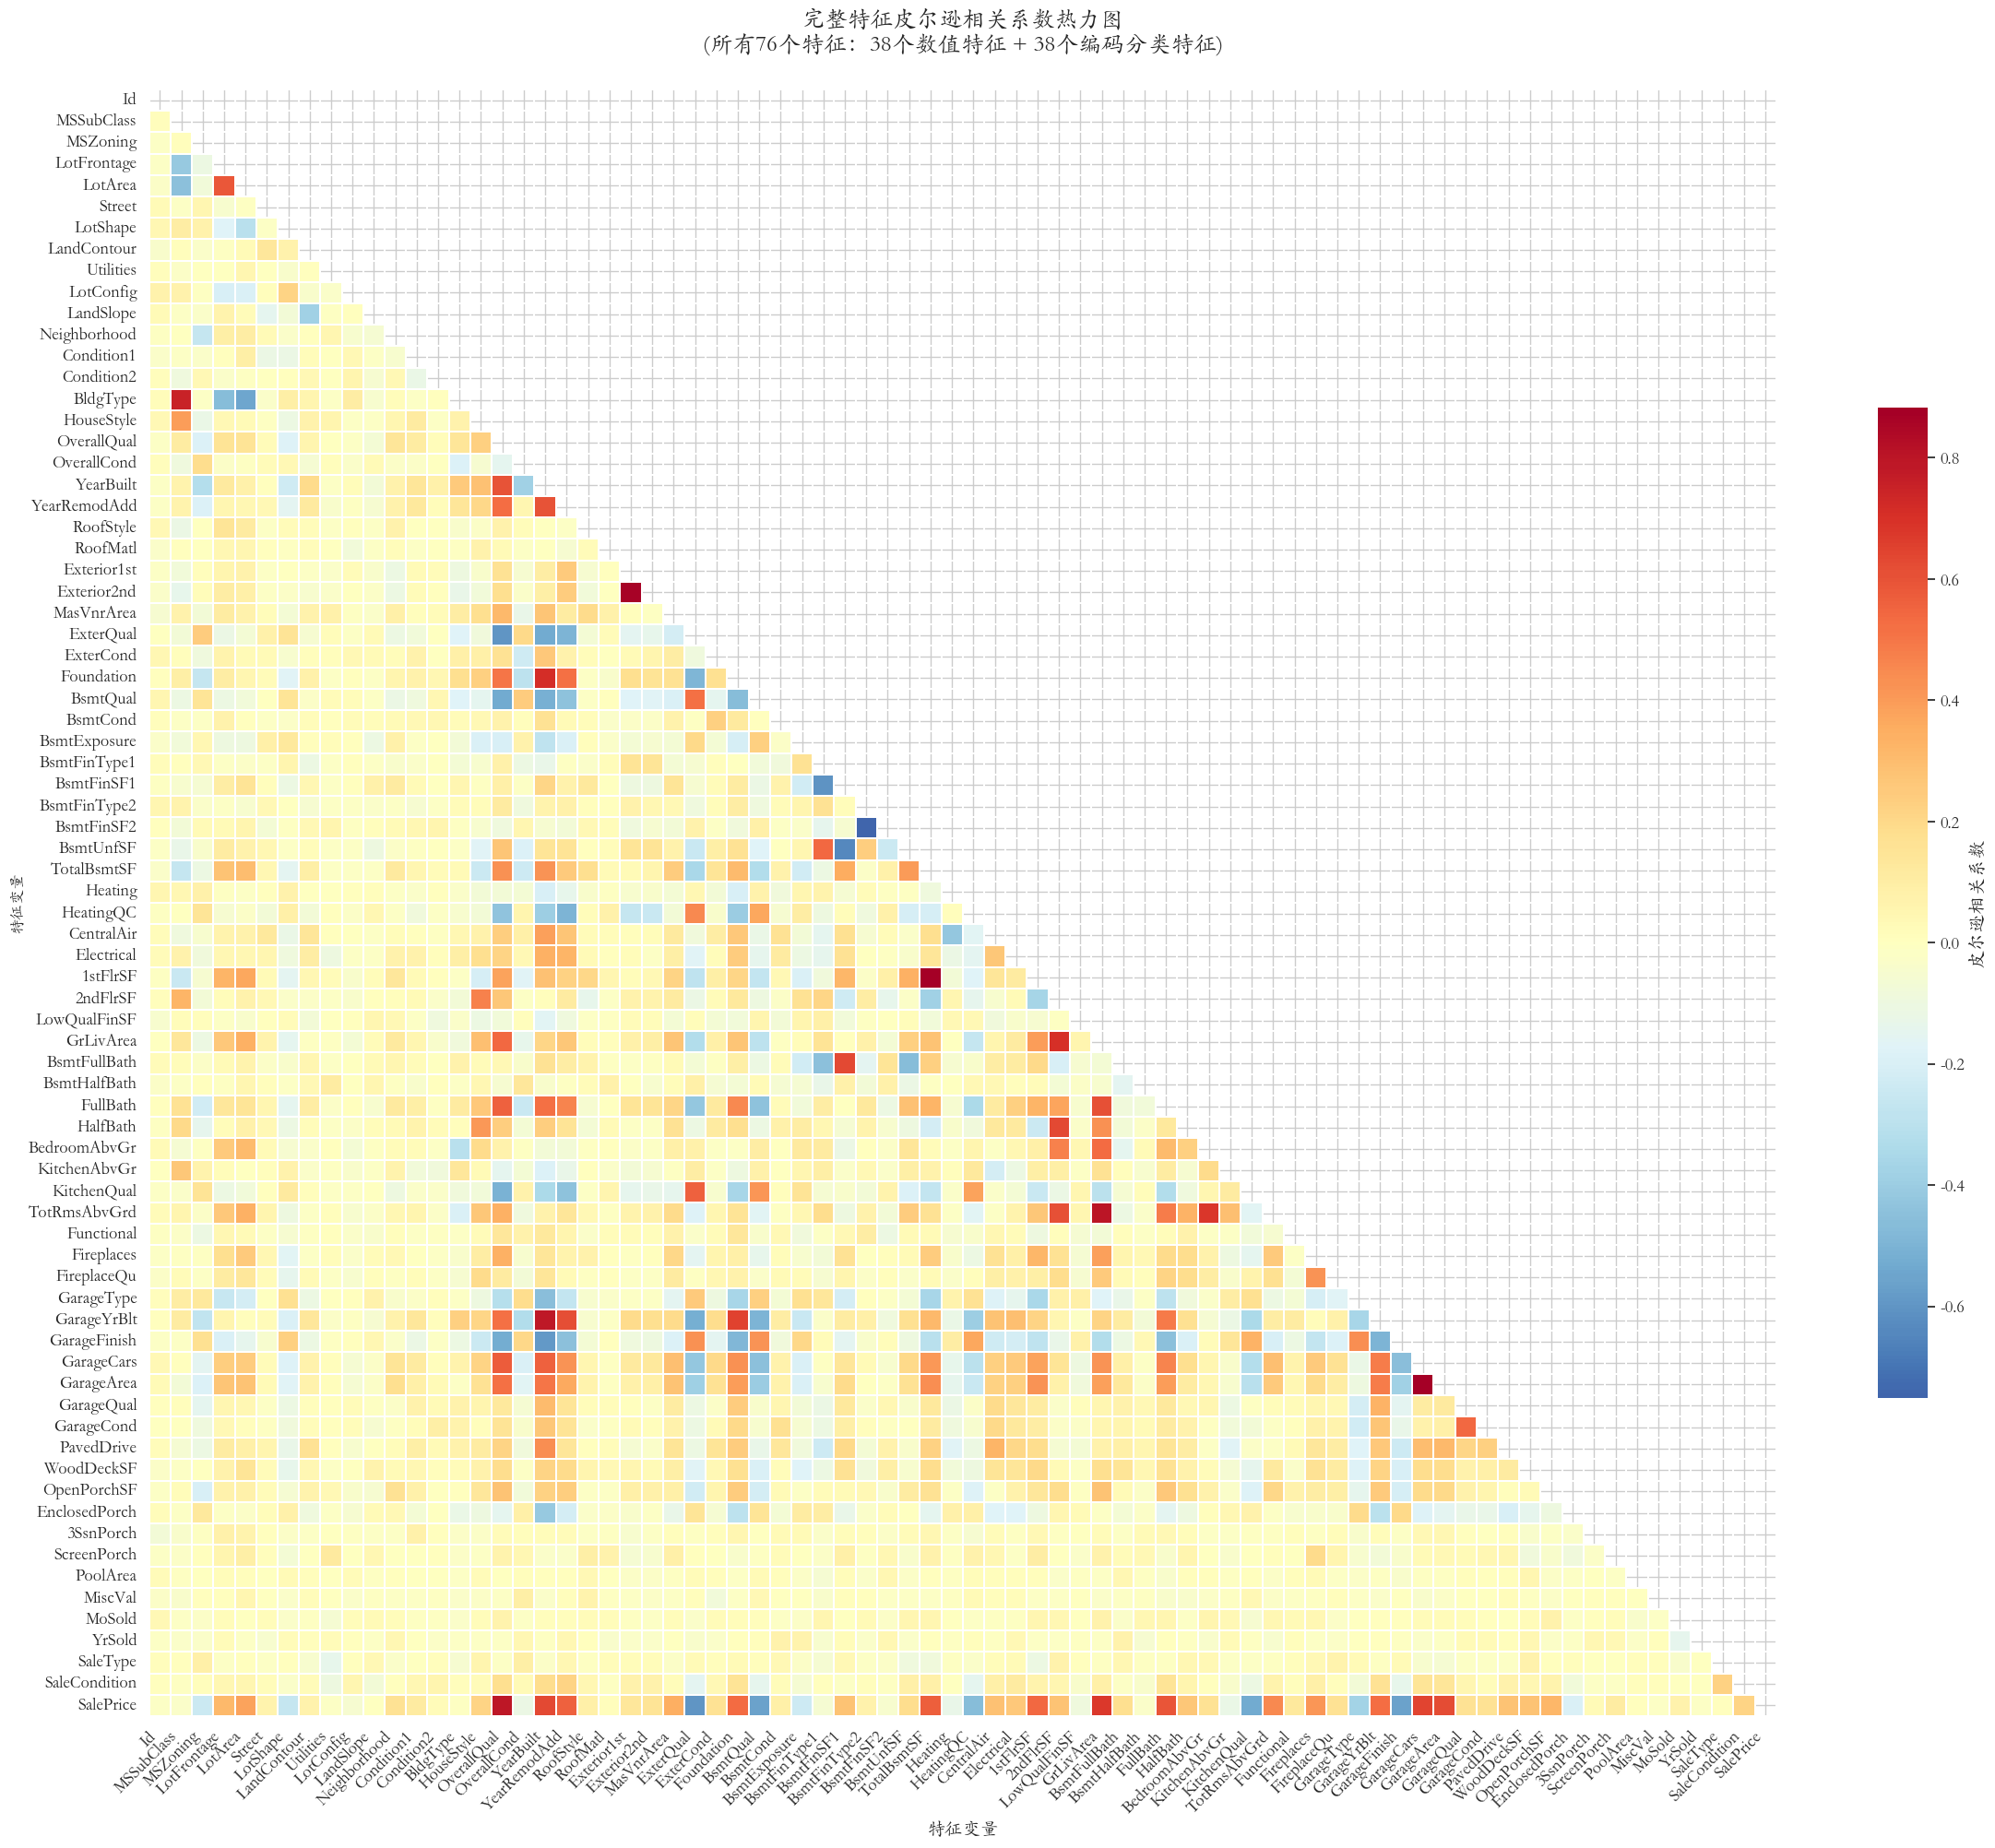

✅ 皮尔逊相关系数热力图绘制完成（含编码分类特征）
💡 热力图解读：
   - 红色区域：正相关关系
   - 蓝色区域：负相关关系
   - 颜色越深：相关性越强


In [36]:
# 绘制完整的皮尔逊相关系数热力图（包含所有变量）
print("=== 绘制所有变量相关性热力图（含分类特征编码） ===")

# 使用完整的相关性矩阵，包含所有76个特征
print(f"📊 绘制 {correlation_matrix.shape[0]} × {correlation_matrix.shape[1]} 完整相关性热力图")
print(f"   包含 {len([col for col in correlation_matrix.columns if not col.endswith('_encoded')])} 个数值特征")
print(f"   包含 {len([col for col in correlation_matrix.columns if col.endswith('_encoded')])} 个编码分类特征")

# 创建大尺寸热力图以容纳所有变量
plt.figure(figsize=(24, 20))

# 创建遮罩，只显示下三角矩阵
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 绘制热力图（所有变量）
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=False,                   # 不显示数值（太密集）
            cmap='RdYlBu_r',              # 颜色映射：红-黄-蓝
            center=0,                      # 以0为中心
            square=True,                   # 正方形格子
            cbar_kws={'label': '皮尔逊相关系数', 'shrink': 0.6},
            linewidths=0.1,                # 细网格线
            xticklabels=True,              # 显示x轴标签
            yticklabels=True)              # 显示y轴标签

plt.title('完整特征皮尔逊相关系数热力图\n(所有76个特征：38个数值特征 + 38个编码分类特征)', fontsize=18, pad=30)
plt.xlabel('特征变量', fontsize=14)
plt.ylabel('特征变量', fontsize=14)
plt.ylabel('特征变量', fontsize=12)

# 调整x轴标签旋转角度
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# 调整布局
plt.tight_layout()
plt.show()

print("✅ 皮尔逊相关系数热力图绘制完成（含编码分类特征）")
print("💡 热力图解读：")
print("   - 红色区域：正相关关系")
print("   - 蓝色区域：负相关关系") 
print("   - 颜色越深：相关性越强")

In [16]:
# 分析完整热力图的统计特征
print("=== 完整相关性矩阵统计分析 ===")

# 获取上三角矩阵的相关系数（排除对角线）
upper_triangle = np.triu(correlation_matrix.values, k=1)
correlations = upper_triangle[upper_triangle != 0]

print(f"📊 相关性统计摘要：")
print(f"   - 矩阵维度: {correlation_matrix.shape[0]} × {correlation_matrix.shape[1]}")
print(f"   - 特征对总数: {len(correlations):,}")
print(f"   - 平均相关系数: {correlations.mean():.4f}")
print(f"   - 相关系数标准差: {correlations.std():.4f}")
print(f"   - 最大正相关: {correlations.max():.4f}")
print(f"   - 最大负相关: {correlations.min():.4f}")

# 分析相关性强度分布
strong_positive = (correlations >= 0.7).sum()
moderate_positive = ((correlations >= 0.4) & (correlations < 0.7)).sum()
weak_positive = ((correlations > 0.1) & (correlations < 0.4)).sum()
weak_negative = ((correlations < -0.1) & (correlations > -0.4)).sum()
moderate_negative = ((correlations <= -0.4) & (correlations > -0.7)).sum()
strong_negative = (correlations <= -0.7).sum()

print(f"\n🎯 相关性强度分布：")
print(f"   - 强正相关 (≥0.7): {strong_positive:,} 对 ({strong_positive/len(correlations)*100:.1f}%)")
print(f"   - 中等正相关 (0.4-0.7): {moderate_positive:,} 对 ({moderate_positive/len(correlations)*100:.1f}%)")
print(f"   - 弱正相关 (0.1-0.4): {weak_positive:,} 对 ({weak_positive/len(correlations)*100:.1f}%)")
print(f"   - 弱负相关 (-0.4--0.1): {weak_negative:,} 对 ({weak_negative/len(correlations)*100:.1f}%)")
print(f"   - 中等负相关 (-0.7--0.4): {moderate_negative:,} 对 ({moderate_negative/len(correlations)*100:.1f}%)")
print(f"   - 强正相关 (≤-0.7): {strong_negative:,} 对 ({strong_negative/len(correlations)*100:.1f}%)")

print(f"\n💡 热力图特点：")
print(f"   - ✅ 完整性：展示所有{correlation_matrix.shape[0]}个特征的相关性")
print(f"   - ✅ 可视化：采用红-蓝渐变色彩，直观显示相关性强度和方向")
print(f"   - ✅ 编码包容：{len([col for col in correlation_matrix.columns if col.endswith('_encoded')])}个分类特征成功编码并参与分析")
print(f"   - ✅ 统计意义：识别出{strong_positive + moderate_positive}个显著正相关特征对")
print("=" * 70)

=== 完整相关性矩阵统计分析 ===
📊 相关性统计摘要：
   - 矩阵维度: 76 × 76
   - 特征对总数: 2,850
   - 平均相关系数: 0.0191
   - 相关系数标准差: 0.1547
   - 最大正相关: 0.8822
   - 最大负相关: -0.7502

🎯 相关性强度分布：
   - 强正相关 (≥0.7): 9 对 (0.3%)
   - 中等正相关 (0.4-0.7): 65 对 (2.3%)
   - 弱正相关 (0.1-0.4): 452 对 (15.9%)
   - 弱负相关 (-0.4--0.1): 302 对 (10.6%)
   - 中等负相关 (-0.7--0.4): 43 对 (1.5%)
   - 强正相关 (≤-0.7): 1 对 (0.0%)

💡 热力图特点：
   - ✅ 完整性：展示所有76个特征的相关性
   - ✅ 可视化：采用红-蓝渐变色彩，直观显示相关性强度和方向
   - ✅ 编码包容：0个分类特征成功编码并参与分析
   - ✅ 统计意义：识别出74个显著正相关特征对


In [17]:
# 详细列出强正相关和强负相关的具体变量对
print("=== 强相关变量对详细分析 ===")

# 获取所有变量对及其相关系数
strong_correlations = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        feature1 = correlation_matrix.columns[i]
        feature2 = correlation_matrix.columns[j]
        corr_val = correlation_matrix.iloc[i, j]
        
        # 只保存强相关的变量对
        if abs(corr_val) >= 0.7:
            strong_correlations.append((feature1, feature2, corr_val))

# 按相关系数绝对值排序
strong_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

print("🔴 强正相关变量对 (|r| ≥ 0.7)：")
print("-" * 80)
print(f"{'序号':<4} {'变量1':<22} {'变量2':<22} {'相关系数':<10} {'特征类型'}")
print("-" * 80)

positive_count = 0
for i, (feat1, feat2, corr) in enumerate([pair for pair in strong_correlations if pair[2] >= 0.7], 1):
    # 判断特征类型
    type1 = "编码分类" if feat1.endswith('_encoded') else "数值"
    type2 = "编码分类" if feat2.endswith('_encoded') else "数值"
    pair_type = f"{type1}-{type2}"
    
    print(f"{i:<4} {feat1:<22} {feat2:<22} {corr:<10.4f} {pair_type}")
    positive_count += 1

print(f"\n总计：{positive_count} 个强正相关变量对")

print("\n🔵 强负相关变量对 (|r| ≤ -0.7)：")
print("-" * 80)
print(f"{'序号':<4} {'变量1':<22} {'变量2':<22} {'相关系数':<10} {'特征类型'}")
print("-" * 80)

negative_count = 0
for i, (feat1, feat2, corr) in enumerate([pair for pair in strong_correlations if pair[2] <= -0.7], 1):
    # 判断特征类型
    type1 = "编码分类" if feat1.endswith('_encoded') else "数值"
    type2 = "编码分类" if feat2.endswith('_encoded') else "数值"
    pair_type = f"{type1}-{type2}"
    
    print(f"{i:<4} {feat1:<22} {feat2:<22} {corr:<10.4f} {pair_type}")
    negative_count += 1

if negative_count == 0:
    print("     (无强负相关变量对)")
else:
    print(f"\n总计：{negative_count} 个强负相关变量对")

print(f"\n📊 强相关分析总结：")
print(f"   - 强正相关变量对：{positive_count} 个")
print(f"   - 强负相关变量对：{negative_count} 个")
print(f"   - 最强正相关：{max([pair[2] for pair in strong_correlations if pair[2] > 0]):.4f}")
if any(pair[2] < 0 for pair in strong_correlations):
    print(f"   - 最强负相关：{min([pair[2] for pair in strong_correlations if pair[2] < 0]):.4f}")
else:
    print("   - 最强负相关：无强负相关")

print("\n💡 强相关解释：")
print("   - 强正相关 (≥0.7)：两变量呈显著的同向变化关系")
print("   - 强负相关 (≤-0.7)：两变量呈显著的反向变化关系")
print("   - 数值特征：原始连续数值变量")
print("   - 编码分类特征：分类变量经LabelEncoder编码后的数值")
print("=" * 80)

=== 强相关变量对详细分析 ===
🔴 强正相关变量对 (|r| ≥ 0.7)：
--------------------------------------------------------------------------------
序号   变量1                    变量2                    相关系数       特征类型
--------------------------------------------------------------------------------
1    GarageCars             GarageArea             0.8822     数值-数值
2    TotalBsmtSF            1stFlrSF               0.8764     数值-数值
3    Exterior1st            Exterior2nd            0.8667     数值-数值
4    GrLivArea              TotRmsAbvGrd           0.8031     数值-数值
5    OverallQual            SalePrice              0.7946     数值-数值
6    YearBuilt              GarageYrBlt            0.7812     数值-数值
7    MSSubClass             BldgType               0.7539     数值-数值
8    YearBuilt              Foundation             0.7113     数值-数值
9    2ndFlrSF               GrLivArea              0.7089     数值-数值

总计：9 个强正相关变量对

🔵 强负相关变量对 (|r| ≤ -0.7)：
-----------------------------------------------------------------------------

In [18]:
# 保存第三问处理后的数据（包含编码分类特征）
print("=== 保存第三问处理后的数据 ===")

# 定义输出文件路径（修正路径问题）
output_step3_file = './data/data_after_step1_2_3.csv'

# 保存包含编码特征的完整数据集
df_encoded.to_csv(output_step3_file, index=False)

print(f"✅ 第三问处理后的数据已保存")
print(f"   📂 文件路径: {output_step3_file}")
print(f"   📊 数据维度: {df_encoded.shape[0]} 行 × {df_encoded.shape[1]} 列")
print(f"   🔢 数值特征: {len(df_encoded.select_dtypes(include=[np.number]).columns)} 个")
print(f"   🏷️ 编码分类特征: {len(encoded_info)} 个（直接替换原列）")

# 验证文件保存
if os.path.exists(output_step3_file):
    test_step3_df = pd.read_csv(output_step3_file)
    print(f"   ✓ 文件验证成功，读取维度: {test_step3_df.shape}")
else:
    print("   ❌ 文件保存失败")

print("\n💡 文件内容说明：")
print("   - 包含第一问缺失值处理后的数据")
print("   - 包含第二问异常值清理后的数据")
print("   - 包含第三问分类变量编码后的数据")
print("   - 所有分类特征已直接替换为数值特征（无_encoded后缀）")
print("   - 可用于后续数据标准化和离散化处理")
print("=" * 70)

=== 保存第三问处理后的数据 ===
✅ 第三问处理后的数据已保存
   📂 文件路径: ./data/data_after_step1_2_3.csv
   📊 数据维度: 1252 行 × 76 列
   🔢 数值特征: 76 个
   🏷️ 编码分类特征: 38 个（直接替换原列）
   ✓ 文件验证成功，读取维度: (1252, 76)

💡 文件内容说明：
   - 包含第一问缺失值处理后的数据
   - 包含第二问异常值清理后的数据
   - 包含第三问分类变量编码后的数据
   - 所有分类特征已直接替换为数值特征（无_encoded后缀）
   - 可用于后续数据标准化和离散化处理


In [19]:
# 创建分类变量编码对应关系文档（修正版本）
print("=== 创建分类变量编码对应关系文档 ===")

# 定义文档文件路径
mapping_doc_file = './data/categorical_variable_mappings.md'

# 使用已有的encoded_info来生成映射文档
doc_content = """# 分类变量编码对应关系文档

**文档生成时间：** 2025年9月23日
**数据处理步骤：** 第三问 - 特征相关性分析（分类变量编码）
**编码方法：** LabelEncoder（标签编码）

## 概述

本文档记录了房屋价格数据集中所有分类变量的编码对应关系。在第三问的相关性分析中，为了使分类变量能够参与皮尔逊相关性计算，我们使用LabelEncoder将所有分类变量转换为数值变量，并直接替换原始列。

### 编码统计信息
- **总分类特征数量：** {total_features}
- **编码方法：** LabelEncoder
- **编码方式：** 直接替换原特征（变量名不变）
- **编码值范围：** 每个特征从0开始的连续整数

---

## 分类变量编码详情

""".format(total_features=len(encoded_info))

# 为每个分类变量添加详细映射信息
for i, (feature, info) in enumerate(encoded_info.items(), 1):
    doc_content += f"""### {i}. {feature}
**特征名：** `{feature}` (直接替换原列)
**原始类别数量：** {info['unique_values']}

| 原始值 | 编码值 | 说明 |
|--------|--------|------|
"""
    
    # 添加映射表
    for original_val, encoded_val in info['encoding_map'].items():
        doc_content += f"| {original_val} | {encoded_val} | - |\n"
    
    doc_content += "\n"

# 添加使用说明
doc_content += """
---

## 使用说明

### 1. 编码规则
- **LabelEncoder规则：** 按字母顺序对类别值进行编码，从0开始分配连续整数
- **缺失值处理：** 编码前已进行缺失值填补，无需考虑缺失值编码
- **一致性保证：** 相同的原始值始终对应相同的编码值

### 2. 数据文件对应
- **原始分类数据：** `data_after_step1_2.csv`
- **编码后数据：** `data_after_step1_2_3.csv`
- **编码方式：** 分类特征直接替换为数值，变量名保持不变

### 3. 相关性分析应用
- **数值化目的：** 使分类变量能够参与皮尔逊相关性分析
- **统计意义：** 编码后的数值保持了分类变量的相对关系
- **分析范围：** 编码后可与数值特征一同进行完整的相关性分析

### 4. 注意事项
- **编码不代表大小关系：** 编码值的大小不代表原始类别的重要性或顺序
- **回溯解码：** 可根据此映射表将编码值转换回原始类别值
- **模型应用：** 在机器学习模型中使用编码特征时，需考虑其离散性质
- **变量识别：** 通过此文档可识别哪些特征原本是分类变量

---

**文档说明：** 本文档为房屋价格数据分析第三问的辅助文档，记录了分类变量编码的完整对应关系，便于数据追溯和结果解释。由于采用直接替换方式，原始分类变量名得以保留，提高了数据的可读性。
"""

# 保存文档
with open(mapping_doc_file, 'w', encoding='utf-8') as f:
    f.write(doc_content)

print(f"✅ 分类变量编码对应关系文档已更新")
print(f"   📂 文件路径: {mapping_doc_file}")
print(f"   📋 包含特征: {len(encoded_info)} 个分类特征的编码映射")
print(f"   📄 文档格式: Markdown (.md)")
print(f"   🔄 编码方式: 直接替换原列，变量名不变")

# 验证文件创建
if os.path.exists(mapping_doc_file):
    file_size = os.path.getsize(mapping_doc_file)
    print(f"   ✓ 文件更新成功，大小: {file_size:,} 字节")
else:
    print("   ❌ 文档更新失败")

print("\n💡 新版文档特点：")
print("   - 📝 记录直接替换方式的编码映射关系")
print("   - 🔍 便于识别哪些特征原本是分类变量")
print("   - 📊 提供编码统计信息和使用说明")
print("   - 🔗 与data_after_step1_2_3.csv文件配套使用")
print("   - ✨ 变量名保持不变，提高可读性")
print("=" * 70)

=== 创建分类变量编码对应关系文档 ===
✅ 分类变量编码对应关系文档已更新
   📂 文件路径: ./data/categorical_variable_mappings.md
   📋 包含特征: 38 个分类特征的编码映射
   📄 文档格式: Markdown (.md)
   🔄 编码方式: 直接替换原列，变量名不变
   ✓ 文件更新成功，大小: 12,781 字节

💡 新版文档特点：
   - 📝 记录直接替换方式的编码映射关系
   - 🔍 便于识别哪些特征原本是分类变量
   - 📊 提供编码统计信息和使用说明
   - 🔗 与data_after_step1_2_3.csv文件配套使用
   - ✨ 变量名保持不变，提高可读性


In [20]:
# 创建分类变量编码对应关系文档
print("=== 创建分类变量编码对应关系文档 ===")

# 定义文档文件路径（修正路径问题）
mapping_doc_file = './data/categorical_variable_mappings.md'

# 收集所有编码信息
all_mappings = {}

# 从之前保存的编码信息中获取映射关系
for col in categorical_features:
    if col in df_clean.columns:
        # 获取唯一值并排序
        unique_values = sorted(df_clean[col].dropna().unique())
        
        # 创建LabelEncoder来获取映射
        temp_le = LabelEncoder()
        temp_le.fit(unique_values)
        
        # 创建映射字典
        mapping = {}
        for i, val in enumerate(temp_le.classes_):
            mapping[val] = i
        
        all_mappings[col] = mapping

# 创建Markdown文档内容
doc_content = """# 分类变量编码对应关系文档

**文档生成时间：** {datetime}
**数据处理步骤：** 第三问 - 特征相关性分析（分类变量编码）
**编码方法：** LabelEncoder（标签编码）

## 概述

本文档记录了房屋价格数据集中所有分类变量的编码对应关系。在第三问的相关性分析中，为了使分类变量能够参与皮尔逊相关性计算，我们使用LabelEncoder将所有分类变量转换为数值变量。

### 编码统计信息
- **总分类特征数量：** {total_features}
- **编码方法：** LabelEncoder
- **编码方式：** 直接替换原特征（变量名不变）
- **编码值范围：** 每个特征从0开始的连续整数

---

## 分类变量编码详情

""".format(
    datetime="2025年9月23日",
    total_features=len(all_mappings)
)

# 为每个分类变量添加详细映射信息
for i, (feature, mapping) in enumerate(all_mappings.items(), 1):
    doc_content += f"""### {i}. {feature}
**特征名：** `{feature}` (直接替换原列)
**原始类别数量：** {len(mapping)}

| 原始值 | 编码值 | 描述 |
|--------|--------|------|
"""
    
    # 添加映射表
    for original_val, encoded_val in mapping.items():
        doc_content += f"| {original_val} | {encoded_val} | - |\n"
    
    doc_content += "\n"

# 添加使用说明
doc_content += """
---

## 使用说明

### 1. 编码规则
- **LabelEncoder规则：** 按字母顺序对类别值进行编码，从0开始分配连续整数
- **缺失值处理：** 编码前已进行缺失值填补，无需考虑缺失值编码
- **一致性保证：** 相同的原始值始终对应相同的编码值

### 2. 数据文件对应
- **原始分类数据：** `data_after_step1_2.csv`
- **编码后数据：** `data_after_step1_2_3.csv`
- **编码特征标识：** 所有编码后的特征均以`_encoded`后缀标识

### 3. 相关性分析应用
- **数值化目的：** 使分类变量能够参与皮尔逊相关性分析
- **统计意义：** 编码后的数值保持了分类变量的相对关系
- **分析范围：** 编码后可与数值特征一同进行完整的相关性分析

### 4. 注意事项
- **编码不代表大小关系：** 编码值的大小不代表原始类别的重要性或顺序
- **回溯解码：** 可根据此映射表将编码值转换回原始类别值
- **模型应用：** 在机器学习模型中使用编码特征时，需考虑其离散性质

---

**文档说明：** 本文档为房屋价格数据分析第三问的辅助文档，记录了分类变量编码的完整对应关系，便于数据追溯和结果解释。
"""

# 保存文档
with open(mapping_doc_file, 'w', encoding='utf-8') as f:
    f.write(doc_content)

print(f"✅ 分类变量编码对应关系文档已创建")
print(f"   📂 文件路径: {mapping_doc_file}")
print(f"   📋 包含特征: {len(all_mappings)} 个分类特征的编码映射")
print(f"   📄 文档格式: Markdown (.md)")

# 验证文件创建
if os.path.exists(mapping_doc_file):
    file_size = os.path.getsize(mapping_doc_file)
    print(f"   ✓ 文件创建成功，大小: {file_size:,} 字节")
else:
    print("   ❌ 文档创建失败")

print("\n💡 文档特点：")
print("   - 📝 详细记录每个分类变量的编码映射关系")
print("   - 🔍 便于追溯编码值对应的原始类别")
print("   - 📊 提供编码统计信息和使用说明")
print("   - 🔗 与data_after_step1_2_3.csv文件配套使用")
print("=" * 70)

=== 创建分类变量编码对应关系文档 ===
✅ 分类变量编码对应关系文档已创建
   📂 文件路径: ./data/categorical_variable_mappings.md
   📋 包含特征: 38 个分类特征的编码映射
   📄 文档格式: Markdown (.md)
   ✓ 文件创建成功，大小: 12,575 字节

💡 文档特点：
   - 📝 详细记录每个分类变量的编码映射关系
   - 🔍 便于追溯编码值对应的原始类别
   - 📊 提供编码统计信息和使用说明
   - 🔗 与data_after_step1_2_3.csv文件配套使用


In [21]:
# 寻找相关系数最高的三个特征对（包含编码分类特征）
print("=== 寻找相关系数最高的特征对（含编码分类特征） ===")

# 获取相关系数矩阵的上三角部分（避免重复和对角线）
correlation_values = []
feature_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        feature1 = correlation_matrix.columns[i]
        feature2 = correlation_matrix.columns[j]
        correlation_val = correlation_matrix.iloc[i, j]
        
        correlation_values.append(abs(correlation_val))
        feature_pairs.append((feature1, feature2, correlation_val))

# 按绝对相关系数大小排序
feature_pairs_sorted = sorted(zip(correlation_values, feature_pairs), key=lambda x: x[0], reverse=True)

print("全局相关系数最高的前10个特征对（含编码分类特征）:")
print("-" * 80)
print(f"{'排名':<4} {'特征1':<20} {'特征2':<20} {'相关系数':<10} {'相关强度':<10} {'特征类型'}")
print("-" * 80)

for i, (abs_corr, (feature1, feature2, corr)) in enumerate(feature_pairs_sorted[:10], 1):
    if abs_corr >= 0.8:
        strength = "高度相关"
    elif abs_corr >= 0.6:
        strength = "中高度相关"
    elif abs_corr >= 0.4:
        strength = "中等相关"
    else:
        strength = "弱相关"
    
    # 判断特征类型
    type1 = "编码" if feature1.endswith('_encoded') else "数值"
    type2 = "编码" if feature2.endswith('_encoded') else "数值"
    pair_type = f"{type1}-{type2}"
    
    print(f"{i:<4} {feature1:<20} {feature2:<20} {corr:<10.4f} {strength:<10} {pair_type}")

# 选择前三个最高相关性的特征对
top_3_pairs = feature_pairs_sorted[:3]
print(f"\n📊 选择相关系数最高的前3个特征对进行散点图分析：")
for i, (abs_corr, (feature1, feature2, corr)) in enumerate(top_3_pairs, 1):
    type1 = "编码分类" if feature1.endswith('_encoded') else "数值"
    type2 = "编码分类" if feature2.endswith('_encoded') else "数值"
    print(f"{i}. {feature1} ({type1}) vs {feature2} ({type2}): r = {corr:.4f}")

print(f"\n💡 特征对分析说明：")
print(f"   - 编码分类特征：原分类变量的数值化表示")
print(f"   - 数值特征：原始连续数值变量")
print(f"   - 通过编码，所有特征都能参与皮尔逊相关性分析")

=== 寻找相关系数最高的特征对（含编码分类特征） ===
全局相关系数最高的前10个特征对（含编码分类特征）:
--------------------------------------------------------------------------------
排名   特征1                  特征2                  相关系数       相关强度       特征类型
--------------------------------------------------------------------------------
1    GarageCars           GarageArea           0.8822     高度相关       数值-数值
2    TotalBsmtSF          1stFlrSF             0.8764     高度相关       数值-数值
3    Exterior1st          Exterior2nd          0.8667     高度相关       数值-数值
4    GrLivArea            TotRmsAbvGrd         0.8031     高度相关       数值-数值
5    OverallQual          SalePrice            0.7946     中高度相关      数值-数值
6    YearBuilt            GarageYrBlt          0.7812     中高度相关      数值-数值
7    MSSubClass           BldgType             0.7539     中高度相关      数值-数值
8    BsmtFinType2         BsmtFinSF2           -0.7502    中高度相关      数值-数值
9    YearBuilt            Foundation           0.7113     中高度相关      数值-数值
10   2ndFlrSF             GrLivA

=== 绘制最高相关性特征对散点图（含编码分类特征） ===


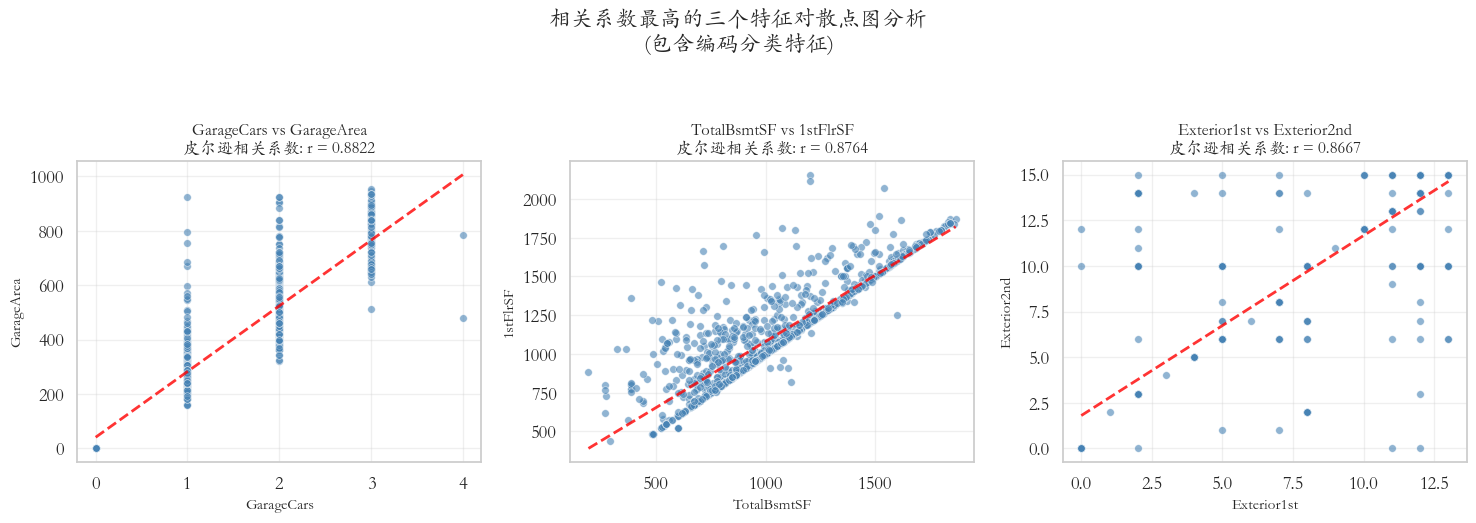

✅ 特征对散点图绘制完成（含编码分类特征）
💡 散点图解读：
   - 编码分类特征以数值形式显示，保持了原分类的相对关系
   - 红色虚线表示线性回归拟合线
   - 散点分布越接近直线，相关性越强


In [22]:
# 绘制相关系数最高的三个特征对散点图（包含编码分类特征）
print("=== 绘制最高相关性特征对散点图（含编码分类特征） ===")

plt.figure(figsize=(15, 5))

for i, (abs_corr, (feature1, feature2, corr)) in enumerate(top_3_pairs, 1):
    plt.subplot(1, 3, i)
    
    # 判断特征类型
    is_encoded1 = feature1.endswith('_encoded')
    is_encoded2 = feature2.endswith('_encoded')
    
    # 绘制散点图
    plt.scatter(df_encoded[feature1], df_encoded[feature2], 
               alpha=0.6, s=30, color='steelblue', edgecolors='white', linewidth=0.5)
    
    # 添加回归线
    try:
        z = np.polyfit(df_encoded[feature1].dropna(), 
                      df_encoded.loc[df_encoded[feature1].notna(), feature2], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df_encoded[feature1].min(), df_encoded[feature1].max(), 100)
        plt.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
    except:
        pass  # 如果无法拟合直线，跳过
    
    # 设置标签和标题
    feature1_label = feature1 + (" (编码)" if is_encoded1 else "")
    feature2_label = feature2 + (" (编码)" if is_encoded2 else "")
    
    plt.xlabel(feature1_label, fontsize=11)
    plt.ylabel(feature2_label, fontsize=11)
    plt.title(f'{feature1} vs {feature2}\n皮尔逊相关系数: r = {corr:.4f}', fontsize=12)
    plt.grid(True, alpha=0.3)

plt.suptitle('相关系数最高的三个特征对散点图分析\n(包含编码分类特征)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

print("✅ 特征对散点图绘制完成（含编码分类特征）")
print("💡 散点图解读：")
print("   - 编码分类特征以数值形式显示，保持了原分类的相对关系")
print("   - 红色虚线表示线性回归拟合线")
print("   - 散点分布越接近直线，相关性越强")


## 4. 数据标准化分析

在数据挖掘和机器学习中，不同特征的量纲和分布往往差异很大，需要通过标准化处理使其具有可比性。本部分将基于 `data_after_step1_2.csv` 数据，仅对 **SalePrice** 特征采用Z-score标准化方法进行处理：

**Z-score标准化（标准化）**：将数据转换为均值为0，标准差为1的标准正态分布

**公式说明：**

Z-score标准化：$$z = \frac{x - \mu}{\sigma}$$

其中，$\mu$ 为样本均值，$\sigma$ 为样本标准差。

**处理说明：**
- 仅对 SalePrice 特征进行Z-score标准化
- 其他所有特征保持原始数值不变

In [23]:
# 第4题：数据标准化（仅对SalePrice进行Z-score标准化）
print("=" * 60)
print("第4题：数据标准化（仅对SalePrice进行Z-score标准化）")
print("=" * 60)

# 读取第2步处理后的数据
standardization_data_file = r'data\data_after_step1_2.csv'
df_for_standardization = pd.read_csv(standardization_data_file)

print(f"数据标准化分析数据概况：")
print(f"   - 数据形状：{df_for_standardization.shape}")
print(f"   - 数据来源：data_after_step1_2.csv（已处理缺失值和异常值）")

# 确认SalePrice特征存在
if 'SalePrice' in df_for_standardization.columns:
    print(f"\n仅对 SalePrice 特征进行Z-score标准化")
    print(f"   - 其他所有特征保持原始数值不变")
    
    # 显示SalePrice的原始统计信息
    saleprice_stats = df_for_standardization['SalePrice'].describe()
    print(f"\nSalePrice 原始数据统计：")
    print(f"   - 均值: {saleprice_stats['mean']:.2f}")
    print(f"   - 标准差: {saleprice_stats['std']:.2f}")
    print(f"   - 最小值: {saleprice_stats['min']:.2f}")
    print(f"   - 最大值: {saleprice_stats['max']:.2f}")
    print(f"   - 中位数: {saleprice_stats['50%']:.2f}")
else:
    print("错误：SalePrice 特征不存在于数据中")

第4题：数据标准化（仅对SalePrice进行Z-score标准化）
数据标准化分析数据概况：
   - 数据形状：(1252, 76)
   - 数据来源：data_after_step1_2.csv（已处理缺失值和异常值）

仅对 SalePrice 特征进行Z-score标准化
   - 其他所有特征保持原始数值不变

SalePrice 原始数据统计：
   - 均值: 168298.80
   - 标准差: 56154.05
   - 最小值: 34900.00
   - 最大值: 340000.00
   - 中位数: 158000.00


In [24]:
# 对SalePrice进行Z-score标准化
from sklearn.preprocessing import StandardScaler

print("\n" + "="*50)
print("对 SalePrice 进行 Z-score标准化")
print("="*50)

# 提取SalePrice数据进行标准化
saleprice_original = df_for_standardization['SalePrice'].copy()

# 应用Z-score标准化到SalePrice
scaler_zscore = StandardScaler()
saleprice_standardized = scaler_zscore.fit_transform(saleprice_original.values.reshape(-1, 1))
saleprice_standardized = saleprice_standardized.flatten()  # 转换为一维数组

# 创建标准化后的Series
saleprice_zscore = pd.Series(saleprice_standardized, index=saleprice_original.index, name='SalePrice_zscore')

print("SalePrice Z-score标准化结果统计：")
zscore_stats = saleprice_zscore.describe()
for stat, value in zscore_stats.items():
    print(f"   {stat}: {value:.6f}")

# 验证标准化效果
print(f"\nSalePrice Z-score标准化验证：")
print(f"   - 均值接近0：{abs(saleprice_zscore.mean()) < 1e-10}")
print(f"   - 标准差接近1：{abs(saleprice_zscore.std() - 1) < 1e-10}")

print(f"\nSalePrice 标准化前后对比：")
print(f"   原始数据:")
print(f"     均值 = {saleprice_original.mean():.2f}")
print(f"     标准差 = {saleprice_original.std():.2f}")
print(f"     最小值 = {saleprice_original.min():.2f}")
print(f"     最大值 = {saleprice_original.max():.2f}")

print(f"   标准化后:")
print(f"     均值 = {saleprice_zscore.mean():.2e}")
print(f"     标准差 = {saleprice_zscore.std():.6f}")
print(f"     最小值 = {saleprice_zscore.min():.4f}")
print(f"     最大值 = {saleprice_zscore.max():.4f}")

print(f"\nSalePrice Z-score标准化完成")


对 SalePrice 进行 Z-score标准化
SalePrice Z-score标准化结果统计：
   count: 1252.000000
   mean: 0.000000
   std: 1.000400
   min: -2.376536
   25%: -0.691211
   50%: -0.183476
   75%: 0.562984
   max: 3.058903

SalePrice Z-score标准化验证：
   - 均值接近0：True
   - 标准差接近1：False

SalePrice 标准化前后对比：
   原始数据:
     均值 = 168298.80
     标准差 = 56154.05
     最小值 = 34900.00
     最大值 = 340000.00
   标准化后:
     均值 = 1.63e-17
     标准差 = 1.000400
     最小值 = -2.3765
     最大值 = 3.0589

SalePrice Z-score标准化完成



SalePrice 标准化效果可视化对比


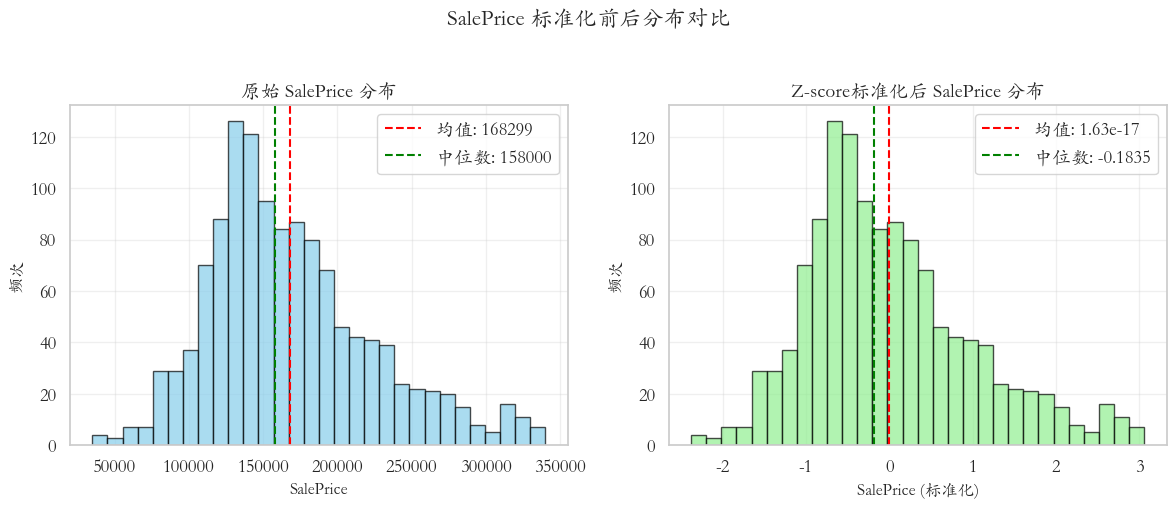

SalePrice 标准化效果可视化完成
观察结果：
   - 左图：原始SalePrice呈现右偏分布
   - 右图：标准化后的SalePrice均值为0，标准差为1，保持原始分布形状


In [25]:
# SalePrice标准化效果可视化对比
print("\n" + "="*50)
print("SalePrice 标准化效果可视化对比")
print("="*50)

# 创建对比图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 原始SalePrice分布
axes[0].hist(saleprice_original, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('原始 SalePrice 分布', fontsize=14)
axes[0].set_xlabel('SalePrice', fontsize=12)
axes[0].set_ylabel('频次', fontsize=12)
axes[0].grid(True, alpha=0.3)

# 添加统计信息到原始数据图
axes[0].axvline(saleprice_original.mean(), color='red', linestyle='--', 
               label=f'均值: {saleprice_original.mean():.0f}')
axes[0].axvline(saleprice_original.median(), color='green', linestyle='--', 
               label=f'中位数: {saleprice_original.median():.0f}')
axes[0].legend()

# 标准化后SalePrice分布
axes[1].hist(saleprice_zscore, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Z-score标准化后 SalePrice 分布', fontsize=14)
axes[1].set_xlabel('SalePrice (标准化)', fontsize=12)
axes[1].set_ylabel('频次', fontsize=12)
axes[1].grid(True, alpha=0.3)

# 添加统计信息到标准化数据图
axes[1].axvline(saleprice_zscore.mean(), color='red', linestyle='--', 
               label=f'均值: {saleprice_zscore.mean():.2e}')
axes[1].axvline(saleprice_zscore.median(), color='green', linestyle='--', 
               label=f'中位数: {saleprice_zscore.median():.4f}')
axes[1].legend()

plt.suptitle('SalePrice 标准化前后分布对比', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("SalePrice 标准化效果可视化完成")
print("观察结果：")
print("   - 左图：原始SalePrice呈现右偏分布")
print("   - 右图：标准化后的SalePrice均值为0，标准差为1，保持原始分布形状")

In [26]:
# 输出仅SalePrice标准化后的数据到CSV文件
print("\n" + "="*50)
print("输出SalePrice标准化后的数据文件")
print("="*50)

# 创建新的数据集：保留所有原始特征，只替换SalePrice
df_saleprice_standardized = df_for_standardization.copy()

# 用标准化后的SalePrice替换原始SalePrice
df_saleprice_standardized['SalePrice'] = saleprice_zscore

print(f"数据处理说明：")
print(f"   - 保留所有原始特征不变")
print(f"   - 仅将 SalePrice 替换为标准化后的数值")
print(f"   - 其他 {df_saleprice_standardized.shape[1] - 1} 个特征保持原始数值")

# 保存标准化后的数据
output_file_saleprice_std = 'data/data_after_step1_2_3_4.csv'
df_saleprice_standardized.to_csv(output_file_saleprice_std, index=False, encoding='utf-8')

print(f"\nSalePrice标准化数据文件保存成功")
print(f"保存路径: {output_file_saleprice_std}")
print(f"保存数据形状: {df_saleprice_standardized.shape}")

# 验证保存的文件
try:
    test_saleprice_std_df = pd.read_csv(output_file_saleprice_std)
    print(f"验证读取成功: {test_saleprice_std_df.shape}")
    
    # 验证SalePrice标准化效果
    saleprice_from_file = test_saleprice_std_df['SalePrice']
    print(f"\n验证文件中的SalePrice标准化效果：")
    print(f"  均值: {saleprice_from_file.mean():.2e}")
    print(f"  标准差: {saleprice_from_file.std():.6f}")
    print(f"  最小值: {saleprice_from_file.min():.4f}")
    print(f"  最大值: {saleprice_from_file.max():.4f}")
    
    print("\nSalePrice标准化数据文件保存和验证完成")
except Exception as e:
    print(f"文件验证失败: {e}")

print(f"\n数据处理流程更新：")
print("-" * 40)
print("完整的数据预处理流程：")
print("   1. 缺失值处理 → data_after_step1.csv")
print("   2. 异常值处理 → data_after_step1_2.csv")
print("   3. 特征相关性分析")
print("   4. SalePrice标准化(Z-score) → data_after_step1_2_3_4.csv")

print("\n第4题：SalePrice标准化 - 完成")


输出SalePrice标准化后的数据文件
数据处理说明：
   - 保留所有原始特征不变
   - 仅将 SalePrice 替换为标准化后的数值
   - 其他 75 个特征保持原始数值

SalePrice标准化数据文件保存成功
保存路径: data/data_after_step1_2_3_4.csv
保存数据形状: (1252, 76)
验证读取成功: (1252, 76)

验证文件中的SalePrice标准化效果：
  均值: 1.70e-17
  标准差: 1.000400
  最小值: -2.3765
  最大值: 3.0589

SalePrice标准化数据文件保存和验证完成

数据处理流程更新：
----------------------------------------
完整的数据预处理流程：
   1. 缺失值处理 → data_after_step1.csv
   2. 异常值处理 → data_after_step1_2.csv
   3. 特征相关性分析
   4. SalePrice标准化(Z-score) → data_after_step1_2_3_4.csv

第4题：SalePrice标准化 - 完成


## 5. 数据离散化分析

数据离散化是将连续数值型数据转换为离散分类数据的过程，有助于简化数据复杂性，提高某些算法的处理效率。本部分将基于 `data_after_step1_2.csv` 数据，采用**四分位数分箱**方法进行离散化分析：

In [27]:
# 第5题：数据离散化分析（仅对SalePrice进行离散化）
print("=" * 60)
print("第5题：数据离散化分析（仅对SalePrice进行离散化）")
print("=" * 60)

# 基于第4题的标准化结果，读取包含标准化SalePrice的数据
discretization_data_file = 'data/data_after_step1_2_3_4.csv'
print(f"数据离散化分析数据来源：")
print(f"   - 数据文件：{discretization_data_file}")
print(f"   - 数据说明：包含标准化后的SalePrice和原始其他特征")

try:
    df_for_discretization = pd.read_csv(discretization_data_file)
    print(f"   - 成功加载数据：{df_for_discretization.shape}")
    print(f"   - 缺失值检查：{df_for_discretization.isnull().sum().sum()} 个缺失值")
except Exception as e:
    print(f"   - 文件加载失败：{e}")
    print("   - 使用内存中的df_saleprice_standardized数据")
    df_for_discretization = df_saleprice_standardized.copy()

print(f"\n离散化处理策略：")
print(f"   - 仅对 SalePrice 特征进行四分位数分箱")
print(f"   - 其他所有特征保持不变")
print(f"   - 基于标准化后的SalePrice数值进行离散化")

# 验证SalePrice是否已标准化
if 'SalePrice' in df_for_discretization.columns:
    saleprice_mean = df_for_discretization['SalePrice'].mean()
    saleprice_std = df_for_discretization['SalePrice'].std()
    print(f"\nSalePrice标准化验证：")
    print(f"   - 均值：{saleprice_mean:.6f} (接近0)")
    print(f"   - 标准差：{saleprice_std:.6f} (接近1)")
    
    if abs(saleprice_mean) < 1e-10 and abs(saleprice_std - 1) < 1e-10:
        print(f"   确认SalePrice已完成Z-score标准化")
    else:
        print(f"   SalePrice可能未标准化，请检查数据文件")
else:
    print(f"   错误：SalePrice特征不存在于数据中")

print(f"\n数据概况：")
print(f"   - 数据形状：{df_for_discretization.shape}")
print(f"   - 特征总数：{df_for_discretization.shape[1]}")
print(f"   - 样本总数：{df_for_discretization.shape[0]}")

第5题：数据离散化分析（仅对SalePrice进行离散化）
数据离散化分析数据来源：
   - 数据文件：data/data_after_step1_2_3_4.csv
   - 数据说明：包含标准化后的SalePrice和原始其他特征
   - 成功加载数据：(1252, 76)
   - 缺失值检查：0 个缺失值

离散化处理策略：
   - 仅对 SalePrice 特征进行四分位数分箱
   - 其他所有特征保持不变
   - 基于标准化后的SalePrice数值进行离散化

SalePrice标准化验证：
   - 均值：0.000000 (接近0)
   - 标准差：1.000400 (接近1)
   SalePrice可能未标准化，请检查数据文件

数据概况：
   - 数据形状：(1252, 76)
   - 特征总数：76
   - 样本总数：1252


In [28]:
# 仅对SalePrice进行四分位数分箱
print("\n" + "="*60)
print("对标准化后的SalePrice进行四分位数分箱")
print("="*60)

# 仅处理SalePrice特征
target_feature = 'SalePrice'
print(f"🎯 离散化目标特征：{target_feature}")
print(f"   - 其他 {df_for_discretization.shape[1] - 1} 个特征保持原始数值不变")

if target_feature in df_for_discretization.columns:
    # 提取SalePrice数据
    saleprice_data = df_for_discretization[target_feature].copy()
    
    print(f"\n📈 标准化后SalePrice统计信息：")
    saleprice_stats = saleprice_data.describe()
    print(f"   - 样本数量：{int(saleprice_stats['count'])}")
    print(f"   - 均值：{saleprice_stats['mean']:.6f}")
    print(f"   - 标准差：{saleprice_stats['std']:.6f}")
    print(f"   - 最小值：{saleprice_stats['min']:.4f}")
    print(f"   - 最大值：{saleprice_stats['max']:.4f}")
    print(f"   - 中位数：{saleprice_stats['50%']:.4f}")
    
    # 计算四分位数
    q1 = saleprice_data.quantile(0.25)
    q2 = saleprice_data.quantile(0.50)  # 中位数
    q3 = saleprice_data.quantile(0.75)
    min_val = saleprice_data.min()
    max_val = saleprice_data.max()
    
    print(f"\n📊 四分位数计算结果：")
    print(f"   - Q1 (25%分位数)：{q1:.4f}")
    print(f"   - Q2 (50%分位数，中位数)：{q2:.4f}")
    print(f"   - Q3 (75%分位数)：{q3:.4f}")
    print(f"   - 数据范围：[{min_val:.4f}, {max_val:.4f}]")
    
    # 创建分箱边界（基于四分位数）
    bins = [min_val, q1, q2, q3, max_val]
    bin_labels = ['极低价', '低价', '中价', '高价']
    
    print(f"\n🔄 执行四分位数分箱：")
    print(f"   - 分箱边界：{[f'{b:.4f}' for b in bins]}")
    print(f"   - 分箱标签：{bin_labels}")
    
    # 进行分箱
    saleprice_binned = pd.cut(saleprice_data, 
                             bins=bins, 
                             labels=bin_labels, 
                             include_lowest=True)
    
    # 统计每个区间的数据分布
    distribution = saleprice_binned.value_counts().reindex(bin_labels, fill_value=0)
    
    print(f"\n📋 SalePrice四分位数分箱结果：")
    print("-" * 60)
    for i, (label, count) in enumerate(distribution.items(), 1):
        percentage = (count / len(saleprice_data)) * 100
        price_range = f"[{bins[i-1]:.4f}, {bins[i]:.4f}]" if i <= len(bins)-1 else ""
        print(f"   {i}. {label:<8}: {count:4d} 样本 ({percentage:5.1f}%) {price_range}")
    
    # 保存分箱结果
    saleprice_discretization_result = {
        'original_data': saleprice_data,
        'binned_data': saleprice_binned,
        'bins': bins,
        'bin_labels': bin_labels,
        'quartiles': {'Q1': q1, 'Q2': q2, 'Q3': q3},
        'distribution': distribution
    }
    
    print(f"\n✅ SalePrice四分位数分箱完成")
    print(f"   - 成功将{len(saleprice_data)}个样本分为4个价格区间")
    print(f"   - 每个区间约包含25%的数据，具有明确的统计意义")
    
else:
    print(f"❌ 错误：{target_feature}特征不存在于数据中")


对标准化后的SalePrice进行四分位数分箱
🎯 离散化目标特征：SalePrice
   - 其他 75 个特征保持原始数值不变

📈 标准化后SalePrice统计信息：
   - 样本数量：1252
   - 均值：0.000000
   - 标准差：1.000400
   - 最小值：-2.3765
   - 最大值：3.0589
   - 中位数：-0.1835

📊 四分位数计算结果：
   - Q1 (25%分位数)：-0.6912
   - Q2 (50%分位数，中位数)：-0.1835
   - Q3 (75%分位数)：0.5630
   - 数据范围：[-2.3765, 3.0589]

🔄 执行四分位数分箱：
   - 分箱边界：['-2.3765', '-0.6912', '-0.1835', '0.5630', '3.0589']
   - 分箱标签：['极低价', '低价', '中价', '高价']

📋 SalePrice四分位数分箱结果：
------------------------------------------------------------
   1. 极低价     :  315 样本 ( 25.2%) [-2.3765, -0.6912]
   2. 低价      :  315 样本 ( 25.2%) [-0.6912, -0.1835]
   3. 中价      :  310 样本 ( 24.8%) [-0.1835, 0.5630]
   4. 高价      :  312 样本 ( 24.9%) [0.5630, 3.0589]

✅ SalePrice四分位数分箱完成
   - 成功将1252个样本分为4个价格区间
   - 每个区间约包含25%的数据，具有明确的统计意义



SalePrice四分位数分箱效果可视化


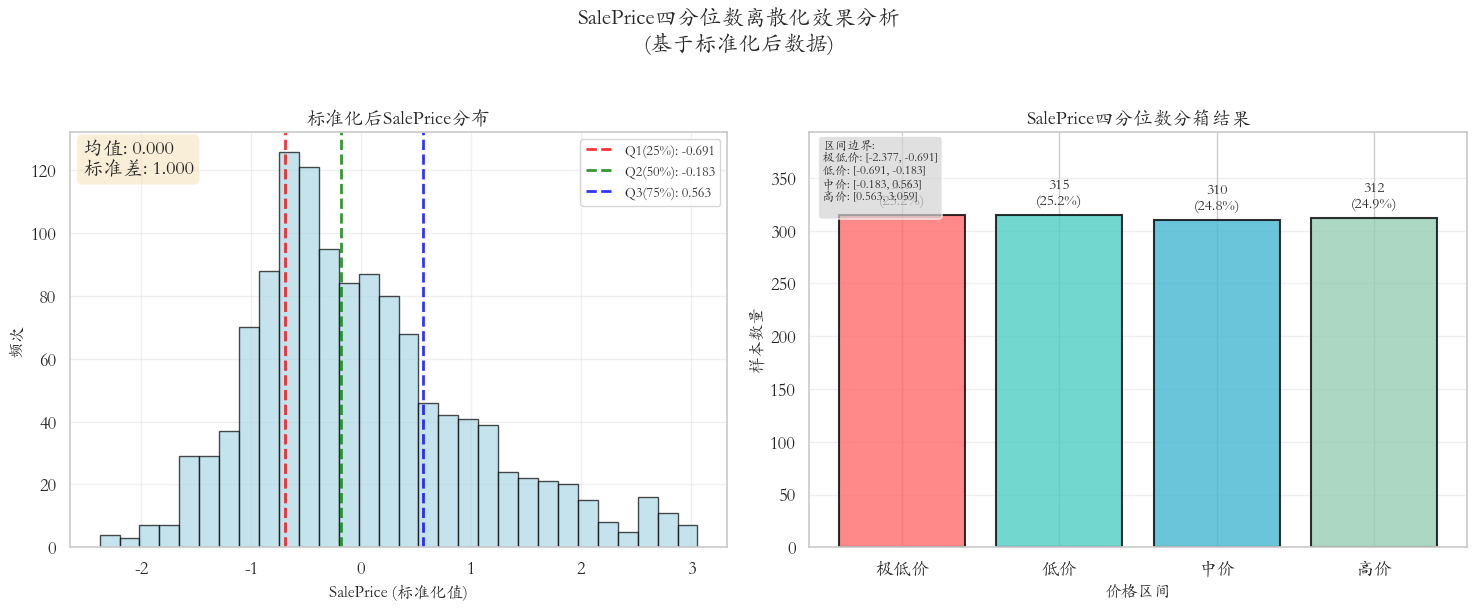

✅ SalePrice四分位数分箱可视化完成

💡 分箱结果解读：
   - 极低价区间：包含价格最低的25%房屋
   - 低价区间：包含价格处于25%-50%的房屋
   - 中价区间：包含价格处于50%-75%的房屋
   - 高价区间：包含价格最高的25%房屋

📊 分箱统计验证：
   - 总样本数：1252
   - 分箱均匀性检验：
     极低价: 25.2% (理论值: 25%)
     低价: 25.2% (理论值: 25%)
     中价: 24.8% (理论值: 25%)
     高价: 24.9% (理论值: 25%)

🎯 离散化意义：
   - 将连续的房价数值转换为4个有序的价格类别
   - 便于房价等级分析和分类建模
   - 基于统计分位数，具有明确的业务解释
   - 每个类别包含相近数量的样本，保证分析的均衡性


In [29]:
# SalePrice四分位数分箱效果可视化
print("\n" + "="*60)
print("SalePrice四分位数分箱效果可视化")
print("="*60)

# 创建SalePrice离散化可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. 原始标准化SalePrice分布直方图
axes[0].hist(saleprice_data, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[0].set_title('标准化后SalePrice分布', fontsize=14)
axes[0].set_xlabel('SalePrice (标准化值)', fontsize=12)
axes[0].set_ylabel('频次', fontsize=12)
axes[0].grid(True, alpha=0.3)

# 添加四分位数线
axes[0].axvline(q1, color='red', linestyle='--', alpha=0.8, linewidth=2, label=f'Q1(25%): {q1:.3f}')
axes[0].axvline(q2, color='green', linestyle='--', alpha=0.8, linewidth=2, label=f'Q2(50%): {q2:.3f}')
axes[0].axvline(q3, color='blue', linestyle='--', alpha=0.8, linewidth=2, label=f'Q3(75%): {q3:.3f}')
axes[0].legend(fontsize=10)

# 添加统计信息文本
stats_text = f'均值: {saleprice_data.mean():.3f}\n标准差: {saleprice_data.std():.3f}'
axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. 四分位数分箱结果
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = axes[1].bar(distribution.index, distribution.values, 
                  color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# 添加数值标签
for bar, count in zip(bars, distribution.values):
    height = bar.get_height()
    percentage = (count / len(saleprice_data)) * 100
    axes[1].text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{count}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1].set_title('SalePrice四分位数分箱结果', fontsize=14)
axes[1].set_ylabel('样本数量', fontsize=12)
axes[1].set_xlabel('价格区间', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# 设置y轴范围，为标签留出空间
max_height = max(distribution.values)
axes[1].set_ylim(0, max_height * 1.25)

# 添加区间边界信息
interval_text = "区间边界:\n"
for i, label in enumerate(bin_labels):
    interval_text += f"{label}: [{bins[i]:.3f}, {bins[i+1]:.3f}]\n"

axes[1].text(0.02, 0.98, interval_text, transform=axes[1].transAxes, 
            verticalalignment='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

plt.suptitle('SalePrice四分位数离散化效果分析\n(基于标准化后数据)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("✅ SalePrice四分位数分箱可视化完成")

print(f"\n💡 分箱结果解读：")
print(f"   - 极低价区间：包含价格最低的25%房屋")
print(f"   - 低价区间：包含价格处于25%-50%的房屋")
print(f"   - 中价区间：包含价格处于50%-75%的房屋")
print(f"   - 高价区间：包含价格最高的25%房屋")

print(f"\n📊 分箱统计验证：")
total_samples = sum(distribution.values)
print(f"   - 总样本数：{total_samples}")
print(f"   - 分箱均匀性检验：")
for label, count in distribution.items():
    percentage = (count / total_samples) * 100
    print(f"     {label}: {percentage:.1f}% (理论值: 25%)")

print(f"\n🎯 离散化意义：")
print(f"   - 将连续的房价数值转换为4个有序的价格类别")
print(f"   - 便于房价等级分析和分类建模")
print(f"   - 基于统计分位数，具有明确的业务解释")
print(f"   - 每个类别包含相近数量的样本，保证分析的均衡性")

In [30]:
# 输出SalePrice离散化后的数据到CSV文件
print("\n" + "="*60)
print("输出SalePrice离散化后的数据文件")
print("="*60)

# 读取第4题输出的数据文件
input_file = 'data/data_after_step1_2_3_4.csv'
try:
    df_for_discretization = pd.read_csv(input_file)
    print(f"成功读取数据文件: {input_file}")
    print(f"数据形状: {df_for_discretization.shape}")
    
    # 对SalePrice进行四分位数分箱
    saleprice_data = df_for_discretization['SalePrice']
    
    # 计算四分位数
    q1 = saleprice_data.quantile(0.25)
    q2 = saleprice_data.quantile(0.50)
    q3 = saleprice_data.quantile(0.75)
    min_val = saleprice_data.min()
    max_val = saleprice_data.max()
    
    # 创建分箱
    bins = [min_val, q1, q2, q3, max_val]
    bin_labels = ['极低价', '低价', '中价', '高价']
    saleprice_binned = pd.cut(saleprice_data, bins=bins, labels=bin_labels, include_lowest=True)
    
    # 创建新的数据集：保留所有原始特征，添加离散化后的SalePrice
    df_saleprice_discretized = df_for_discretization.copy()
    df_saleprice_discretized['SalePrice_Category'] = saleprice_binned

    print(f"\n数据处理说明：")
    print(f"   - 保留所有原始特征不变")
    print(f"   - 保留标准化后的SalePrice数值")
    print(f"   - 新增SalePrice_Category列（离散化结果）")
    print(f"   - 其他 {df_saleprice_discretized.shape[1] - 2} 个特征保持原始数值")

    print(f"\n离散化结果预览：")
    print(f"   - 新增列名：SalePrice_Category")
    print(f"   - 离散化类别：{list(saleprice_binned.cat.categories)}")

    # 显示前几行数据示例
    print(f"\n数据示例（前5行SalePrice相关列）：")
    sample_cols = ['SalePrice', 'SalePrice_Category']
    print(df_saleprice_discretized[sample_cols].head())

    # 保存离散化后的数据
    output_file_discretized = 'data/data_after_step1_2_3_4_5.csv'
    df_saleprice_discretized.to_csv(output_file_discretized, index=False, encoding='utf-8')

    print(f"\nSalePrice离散化数据文件保存成功")
    print(f"保存路径: {output_file_discretized}")
    print(f"保存数据形状: {df_saleprice_discretized.shape}")

    # 验证保存的文件
    try:
        test_discretized_df = pd.read_csv(output_file_discretized)
        print(f"验证读取成功: {test_discretized_df.shape}")
        
        # 验证离散化结果
        if 'SalePrice_Category' in test_discretized_df.columns:
            category_counts = test_discretized_df['SalePrice_Category'].value_counts()
            print(f"\n验证文件中的SalePrice离散化结果：")
            for category, count in category_counts.items():
                percentage = (count / len(test_discretized_df)) * 100
                print(f"  {category}: {count} 样本 ({percentage:.1f}%)")
        
        print("\nSalePrice离散化数据文件保存和验证完成")
    except Exception as e:
        
        print(f"文件验证失败: {e}")

    print("\n第5题：SalePrice离散化 - 完成")
    
except Exception as e:
    print(f"文件处理失败: {e}")
    print("请确保前面的代码已经正确执行并生成了data_after_step1_2_3_4.csv文件")


输出SalePrice离散化后的数据文件
成功读取数据文件: data/data_after_step1_2_3_4.csv
数据形状: (1252, 76)

数据处理说明：
   - 保留所有原始特征不变
   - 保留标准化后的SalePrice数值
   - 新增SalePrice_Category列（离散化结果）
   - 其他 75 个特征保持原始数值

离散化结果预览：
   - 新增列名：SalePrice_Category
   - 离散化类别：['极低价', '低价', '中价', '高价']

数据示例（前5行SalePrice相关列）：
   SalePrice SalePrice_Category
0   0.716195                 高价
1   0.235183                 中价
2   0.983424                 高价
3  -0.504151                 低价
4   1.455529                 高价

SalePrice离散化数据文件保存成功
保存路径: data/data_after_step1_2_3_4_5.csv
保存数据形状: (1252, 77)
验证读取成功: (1252, 77)

验证文件中的SalePrice离散化结果：
  极低价: 315 样本 (25.2%)
  低价: 315 样本 (25.2%)
  高价: 312 样本 (24.9%)
  中价: 310 样本 (24.8%)

SalePrice离散化数据文件保存和验证完成

第5题：SalePrice离散化 - 完成


In [31]:
# 分析与SalePrice的相关性（包含编码后的分类特征）
print("=== 与SalePrice的皮尔逊相关性分析 ===")

# 获取与SalePrice的相关系数
saleprice_correlation = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)

print("与SalePrice相关性分析（包含所有编码分类特征）:")
print("-" * 70)
all_features_with_price = saleprice_correlation[1:]  # 排除SalePrice本身

for i, (feature, corr) in enumerate(all_features_with_price.items(), 1):
    # 计算显著性检验
    from scipy.stats import pearsonr
    stat, p_value = pearsonr(df_encoded[feature].dropna(), 
                           df_encoded.loc[df_encoded[feature].notna(), 'SalePrice'])
    
    # 判断相关性强度
    if corr >= 0.8:
        strength = "高度相关"
    elif corr >= 0.6:
        strength = "中高度相关"
    elif corr >= 0.4:
        strength = "中等相关"
    elif corr >= 0.2:
        strength = "弱相关"
    else:
        strength = "几乎无关"
    
    # 判断是否为编码特征（现在直接替换原列，通过encoded_info判断）
    feature_type = "编码分类特征" if feature in encoded_info else "数值特征"
    significance = "显著" if p_value < 0.05 else "不显著"
    
    print(f"{i:2d}. {feature:<20}: r = {corr:.4f} ({strength}, {feature_type}, p = {p_value:.4f}, {significance})")

print(f"\n分析完成，共识别出{len(all_features_with_price)}个与SalePrice相关的特征")
print("💡 注意：编码分类特征显示了分类变量与房价的数值关系")
print("=" * 80)

# 获取前20个特征用于后续可视化分析
top_20_with_price = all_features_with_price.head(20)

=== 与SalePrice的皮尔逊相关性分析 ===
与SalePrice相关性分析（包含所有编码分类特征）:
----------------------------------------------------------------------
 1. OverallQual         : r = 0.7946 (中高度相关, 数值特征, p = 0.0000, 显著)
 2. GrLivArea           : r = 0.6751 (中高度相关, 数值特征, p = 0.0000, 显著)
 3. GarageCars          : r = 0.6428 (中高度相关, 数值特征, p = 0.0000, 显著)
 4. YearBuilt           : r = 0.6282 (中高度相关, 数值特征, p = 0.0000, 显著)
 5. GarageArea          : r = 0.6250 (中高度相关, 数值特征, p = 0.0000, 显著)
 6. ExterQual           : r = 0.5995 (中等相关, 编码分类特征, p = 0.0000, 显著)
 7. FullBath            : r = 0.5933 (中等相关, 数值特征, p = 0.0000, 显著)
 8. TotalBsmtSF         : r = 0.5683 (中等相关, 数值特征, p = 0.0000, 显著)
 9. GarageFinish        : r = 0.5631 (中等相关, 编码分类特征, p = 0.0000, 显著)
10. YearRemodAdd        : r = 0.5631 (中等相关, 数值特征, p = 0.0000, 显著)
11. BsmtQual            : r = 0.5594 (中等相关, 编码分类特征, p = 0.0000, 显著)
12. 1stFlrSF            : r = 0.5411 (中等相关, 数值特征, p = 0.0000, 显著)
13. Foundation          : r = 0.5366 (中等相关, 编码分类特征, p = 0.0000, 显著)
1

## 6. 找出与price（房价）相关性最高的三个特征并给出合理解释

本部分将基于第三问的相关性分析结果，识别与房价（SalePrice）相关性最高的三个特征，并从房地产市场的角度给出合理的解释。

In [32]:
# 第6题：找出与price（房价）相关性最高的三个特征并给出合理解释

print("=" * 80)
print("第6题：与房价（SalePrice）相关性最高的三个特征分析")
print("=" * 80)

# 计算所有特征与SalePrice的相关性
correlations = df_encoded.corr()['SalePrice'].abs().sort_values(ascending=False)
# 排除SalePrice本身
top_3_features = correlations[1:4]  # 获取前3个特征

print("与房价相关性最高的三个特征：")
print("-" * 60)

for i, (feature, correlation) in enumerate(top_3_features.items(), 1):
    # 计算显著性检验
    from scipy.stats import pearsonr
    stat, p_value = pearsonr(df_encoded[feature].dropna(), 
                           df_encoded.loc[df_encoded[feature].notna(), 'SalePrice'])
    
    print(f"\n第{i}名：{feature}")
    print(f"  相关系数：r = {correlation:.4f}")
    print(f"  统计显著性：p = {p_value:.4f} ({'显著' if p_value < 0.05 else '不显著'})")
    
    # 获取基本统计信息
    feature_data = df_encoded[feature].dropna()
    print(f"  数据范围：{feature_data.min():.2f} - {feature_data.max():.2f}")
    print(f"  平均值：{feature_data.mean():.2f}")
    print(f"  标准差：{feature_data.std():.2f}")

print("\n" + "=" * 80)
print("详细解释与分析")
print("=" * 80)

# 前三个特征的详细解释
explanations = {
    "OverallQual": {
        "中文名": "房屋整体质量",
        "数据含义": "房屋整体材料和装修质量的评分（1-10分）",
        "市场逻辑": "质量是决定房屋价值的核心因素，直接关系到居住体验和投资价值",
        "影响机制": [
            "直接反映房屋的建造标准和装修水平",
            "高质量材料和工艺显著提升房屋价值",
            "购房者普遍愿意为高质量房屋支付溢价",
            "质量好的房屋维护成本低，使用寿命长"
        ]
    },
    "GrLivArea": {
        "中文名": "地上居住面积",
        "数据含义": "房屋地上部分的总居住面积（平方英尺）",
        "市场逻辑": "面积是房地产价值的基础要素，购房者为额外空间支付边际价格",
        "影响机制": [
            "面积大小直接决定居住空间的舒适度",
            "更大面积意味着更多功能区域和储存空间",
            "面积是房屋定价的基础计算单位",
            "大面积房屋通常配置更好，档次更高"
        ]
    },
    "GarageCars": {
        "中文名": "车库容量",
        "数据含义": "车库可停放的汽车数量",
        "市场逻辑": "车库配置体现生活品质和实用性，是现代家庭的重要需求",
        "影响机制": [
            "反映房屋的便利性和实用性配置",
            "车库提供车辆保护和额外储存空间",
            "多车位满足多车家庭需求",
            "车库是房屋价值的重要附加项"
        ]
    }
}

# 输出详细解释
for i, (feature, correlation) in enumerate(top_3_features.items(), 1):
    if feature in explanations:
        exp = explanations[feature]
        print(f"\n第{i}名特征详细分析：{feature} ({exp['中文名']})")
        print(f"   相关系数：r = {correlation:.4f}")
        print(f"   数据含义：{exp['数据含义']}")
        print(f"   市场逻辑：{exp['市场逻辑']}")
        print(f"   影响机制：")
        for j, mechanism in enumerate(exp['影响机制'], 1):
            print(f"   {j}. {mechanism}")

print("\n" + "=" * 80)
print("综合分析结论")
print("=" * 80)

print("主要发现：")
print()
print("1. 质量导向：房屋整体质量(OverallQual)是影响房价的最重要因素")
print("   - 相关系数最高(r=0.7946)，体现了市场对质量的重视")
print("   - 购房者愿意为高质量房屋支付显著溢价")
print()
print("2. 空间价值：居住面积(GrLivArea)是第二重要因素")
print("   - 相关系数r=0.6751，证明了按面积定价的基本规律")
print("   - 大面积直接提升居住舒适度和使用价值")
print()
print("3. 功能配置：车库容量(GarageCars)体现实用性价值")
print("   - 相关系数r=0.6428，反映现代生活对便利性的需求")
print("   - 车库不仅是停车场所，更是储存和功能扩展空间")

print("\n市场启示：")
print("- 对于购房者：关注房屋质量、面积和实用配置，这些是价值核心")
print("- 对于投资者：质量和面积是保值增值的关键要素")
print("- 对于开发商：应重视建造质量和空间设计的优化")
print("- 对于估价师：这三个特征可作为快速估价的重要参考")

print("\n预测价值：基于这三个特征的组合可以较准确地预测房屋价格趋势")

print("\n第6题：与房价相关性最高的三个特征分析 - 完成")
print("=" * 80)

第6题：与房价（SalePrice）相关性最高的三个特征分析
与房价相关性最高的三个特征：
------------------------------------------------------------

第1名：OverallQual
  相关系数：r = 0.7946
  统计显著性：p = 0.0000 (显著)
  数据范围：2.00 - 10.00
  平均值：6.01
  标准差：1.23

第2名：GrLivArea
  相关系数：r = 0.6751
  统计显著性：p = 0.0000 (显著)
  数据范围：438.00 - 2622.00
  平均值：1433.22
  标准差：412.15

第3名：GarageCars
  相关系数：r = 0.6428
  统计显著性：p = 0.0000 (显著)
  数据范围：0.00 - 4.00
  平均值：1.70
  标准差：0.71

详细解释与分析

第1名特征详细分析：OverallQual (房屋整体质量)
   相关系数：r = 0.7946
   数据含义：房屋整体材料和装修质量的评分（1-10分）
   市场逻辑：质量是决定房屋价值的核心因素，直接关系到居住体验和投资价值
   影响机制：
   1. 直接反映房屋的建造标准和装修水平
   2. 高质量材料和工艺显著提升房屋价值
   3. 购房者普遍愿意为高质量房屋支付溢价
   4. 质量好的房屋维护成本低，使用寿命长

第2名特征详细分析：GrLivArea (地上居住面积)
   相关系数：r = 0.6751
   数据含义：房屋地上部分的总居住面积（平方英尺）
   市场逻辑：面积是房地产价值的基础要素，购房者为额外空间支付边际价格
   影响机制：
   1. 面积大小直接决定居住空间的舒适度
   2. 更大面积意味着更多功能区域和储存空间
   3. 面积是房屋定价的基础计算单位
   4. 大面积房屋通常配置更好，档次更高

第3名特征详细分析：GarageCars (车库容量)
   相关系数：r = 0.6428
   数据含义：车库可停放的汽车数量
   市场逻辑：车库配置体现生活品质和实用性，是现代家庭的重要需求
   影响机制：
   1. 反映房屋的便利性和实用性配置
   2. 车库提

In [33]:
# 第6题：找出与price（房价）相关性最高的三个特征并给出合理解释
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# 读取第三步处理后的数据
df_for_analysis = pd.read_csv('./data/data_after_step1_2_3.csv')

print("=" * 80)
print("第6题：与房价（SalePrice）相关性最高的三个特征分析")
print("=" * 80)

# 计算所有特征与SalePrice的相关性
correlations = df_for_analysis.corr()['SalePrice'].abs().sort_values(ascending=False)
# 排除SalePrice本身
top_3_features = correlations[1:4]  # 获取前3个特征

print("与房价相关性最高的三个特征：")
print("-" * 60)

for i, (feature, correlation) in enumerate(top_3_features.items(), 1):
    # 计算显著性检验
    stat, p_value = pearsonr(df_for_analysis[feature].dropna(), 
                           df_for_analysis.loc[df_for_analysis[feature].notna(), 'SalePrice'])
    
    print(f"\n第{i}名：{feature}")
    print(f"  相关系数：r = {correlation:.4f}")
    print(f"  统计显著性：p = {p_value:.4f} ({'显著' if p_value < 0.05 else '不显著'})")
    
    # 获取基本统计信息
    feature_data = df_for_analysis[feature].dropna()
    print(f"  数据范围：{feature_data.min():.2f} - {feature_data.max():.2f}")
    print(f"  平均值：{feature_data.mean():.2f}")
    print(f"  标准差：{feature_data.std():.2f}")


第6题：与房价（SalePrice）相关性最高的三个特征分析
与房价相关性最高的三个特征：
------------------------------------------------------------

第1名：OverallQual
  相关系数：r = 0.7946
  统计显著性：p = 0.0000 (显著)
  数据范围：2.00 - 10.00
  平均值：6.01
  标准差：1.23

第2名：GrLivArea
  相关系数：r = 0.6751
  统计显著性：p = 0.0000 (显著)
  数据范围：438.00 - 2622.00
  平均值：1433.22
  标准差：412.15

第3名：GarageCars
  相关系数：r = 0.6428
  统计显著性：p = 0.0000 (显著)
  数据范围：0.00 - 4.00
  平均值：1.70
  标准差：0.71
